In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Настройка стилей визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

In [2]:
!unzip dataset.zip

Archive:  dataset.zip
  inflating: словарь_соцдема.csv  
  inflating: датасет_new.csv  


In [20]:
df1 = pd.read_csv('датасет_new.csv')
df2 = pd.read_csv('словарь_соцдема.csv')

# Переименование столбцов
df1.columns = ['event_dt', 'screen', 'feature', 'action',
              'device_id', 'session_id', 'device_vendor',
              'device_model', 'device_type', 'os']

df2.columns = ['device_id', 'age', 'gender']

Общая информация о датасетах

In [19]:
print(f"\nРазмер основного датасета: {df1.shape}")
print(f"Количество строк: {df1.shape[0]:,}")
print(f"Количество столбцов: {df1.shape[1]}")
print(f"\nРазмер словаря: {df2.shape}")
print(f"Уникальных пользователей: {df2['device_id'].nunique():,}")

# Базовый анализ
print("\nИНФОРМАЦИЯ О ДАТАСЕТЕ:")
print(df1.info())

print("\nСТАТИСТИКА ПО ЧИСЛОВЫМ СТОЛБЦАМ:")
print(df1.describe().T)

print("\nСТАТИСТИКА ПО КАТЕГОРИАЛЬНЫМ СТОЛБЦАМ:")
categorical_cols = ['screen', 'feature', 'action', 'device_vendor',
                    'device_model', 'device_type', 'os']
for col in categorical_cols:
    if col in df1.columns:
        print(f"\n{col}:")
        print(f"  Уникальных значений: {df1[col].nunique()}")
        print(f"  Топ-5 самых частых:")
        for val, count in df1[col].value_counts().head().items():
            print(f"    {val}: {count:,} ({count/len(df1)*100:.1f}%)")


Размер основного датасета: (6269242, 10)
Количество строк: 6,269,242
Количество столбцов: 10

Размер словаря: (180341, 3)
Уникальных пользователей: 180,341

ИНФОРМАЦИЯ О ДАТАСЕТЕ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6269242 entries, 0 to 6269241
Data columns (total 10 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   event_dt       object
 1   screen         object
 2   feature        object
 3   action         object
 4   device_id      int64 
 5   session_id     int64 
 6   device_vendor  object
 7   device_model   object
 8   device_type    object
 9   os             object
dtypes: int64(2), object(8)
memory usage: 478.3+ MB
None

СТАТИСТИКА ПО ЧИСЛОВЫМ СТОЛБЦАМ:
                count          mean           std           min           25%  \
device_id   6269242.0  5.940995e+04  45758.020465  1.000000e+00  2.255000e+04   
session_id  6269242.0  1.000000e+10    847.857164  1.000000e+10  1.000000e+10   

                     50%           75%         

In [21]:
print("\nПервые 5 строк основного датасета:")
print(df1.head())

print("\nПервые 5 строк словаря:")
print(df2.head())


Первые 5 строк основного датасета:
                                   event_dt screen                    feature  \
0  2025-09-29T10:20:27+03:00[Europe/Moscow]    Еще            Открытие экрана   
1  2025-09-29T10:20:27+03:00[Europe/Moscow]    Еще            Открытие экрана   
2  2025-09-29T10:21:56+03:00[Europe/Moscow]    Еще            Открытие экрана   
3  2025-09-29T10:21:56+03:00[Europe/Moscow]    Еще            Открытие экрана   
4  2025-09-29T10:22:01+03:00[Europe/Moscow]    Еще  Переход в раздел 'Заявки'   

                   action  device_id   session_id device_vendor  \
0                     NaN        339  10000000009         Redmi   
1                     NaN        339  10000000009         Redmi   
2                     NaN        339  10000000009         Redmi   
3                     NaN        339  10000000009         Redmi   
4  Тап на кнопку 'Заявки'        339  10000000009         Redmi   

    device_model device_type       os  
0  Redmi Note 12       phone  Andr

Очистка данных

In [22]:
# Анализ дубликатов
print(f"\nИз {df1.shape[0]} строк в основном датасете, дубликатов {df1.duplicated().sum()}")
print(f"Из {df2.shape[0]} строк в словаре, дубликатов {df2.duplicated().sum()}")

# Удаление дубликатов
print("\nУдаление дубликатов...")
df1 = df1.drop_duplicates()
print(f"{df1.shape[0]} строк осталось после удаления дубликатов.")


Из 6269242 строк в основном датасете, дубликатов 2908592
Из 180341 строк в словаре, дубликатов 0

Удаление дубликатов...
3360650 строк осталось после удаления дубликатов.


In [23]:
# Объединение данных
print("\nОбъединение данных...")
mask_missing = ~df1["device_id"].isin(df2["device_id"])
missing_ids = df1.loc[mask_missing, "device_id"].unique()
num_lost = len(missing_ids)
print(f"Количество устройств, присутствующих в основном датасете, но отсутствующих в словаре: {num_lost}")

df = df1.merge(df2, on='device_id', how='left')
print(f"Размер объединенного датафрейма: {df.shape}")


Объединение данных...
Количество устройств, присутствующих в основном датасете, но отсутствующих в словаре: 0
Размер объединенного датафрейма: (3360650, 12)


In [24]:
print("АНАЛИЗ ДАННЫХ")

if df['event_dt'].dtype == 'object':
    df['event_dt'] = pd.to_datetime(
        df['event_dt'].str.split('[').str[0],
        format='mixed'
    )
    print("  Преобразование завершено")
else:
    print(f"  event_dt уже имеет тип: {df['event_dt'].dtype}")

# Создаем вспомогательные колонки
df['date'] = df['event_dt'].dt.date
df['month'] = df['event_dt'].dt.month
df['year'] = df['event_dt'].dt.year

print(f"  Тип event_dt: {df['event_dt'].dtype}")
print(f"  Период: с {df['date'].min()} по {df['date'].max()}")
print(f"  Месяцы: {sorted(df['month'].unique())}")

АНАЛИЗ ДАННЫХ
  Преобразование завершено
  Тип event_dt: datetime64[ns, UTC+03:00]
  Период: с 2025-09-01 по 2025-10-31
  Месяцы: [np.int32(9), np.int32(10)]


In [25]:
# Фильтруем данные с 1 сентября
df_sep_oct = df[df['month'].isin([9, 10])].copy()

print(f"\nДанные с сентября-октября:")
print(f"  Период: с {df_sep_oct['date'].min()} по {df_sep_oct['date'].max()}")
print(f"  Всего строк: {len(df_sep_oct):,}")
print(f"  Уникальных пользователей: {df_sep_oct['device_id'].nunique():,}")


Данные с сентября-октября:
  Период: с 2025-09-01 по 2025-10-31
  Всего строк: 3,360,650
  Уникальных пользователей: 179,976


Статистика по дням и месяцам

In [26]:
# 4. Статистика по дням
print("\nСТАТИСТИКА ПО ДНЯМ:")

daily_stats = df_sep_oct.groupby('date').agg({
    'device_id': ['count', 'nunique'],
    'session_id': 'nunique'
})

daily_stats.columns = ['Событий', 'Уникальных пользователей', 'Уникальных сессий']

# Добавляем информацию о дне
date_index = pd.to_datetime(daily_stats.index)
daily_stats['День недели'] = date_index.day_name()
daily_stats['День месяца'] = date_index.day
daily_stats['Месяц'] = date_index.month

# Переупорядочиваем
daily_stats = daily_stats[['Месяц', 'День месяца', 'День недели',
                           'Событий', 'Уникальных пользователей', 'Уникальных сессий']]

print("Первые 15 дней:")
print(daily_stats.head(15).to_string(formatters={
    'Событий': '{:,}'.format,
    'Уникальных пользователей': '{:,}'.format,
    'Уникальных сессий': '{:,}'.format
}))

# 5. Статистика по месяцам
print("\nСТАТИСТИКА ПО МЕСЯЦАМ:")

monthly_stats = df_sep_oct.groupby('month').agg({
    'device_id': ['count', 'nunique'],
    'session_id': 'nunique'
})

monthly_stats.columns = ['Событий', 'Уникальных пользователей', 'Уникальных сессий']

# Переименовываем месяцы для читаемости
month_names = {9: 'Сентябрь', 10: 'Октябрь'}
monthly_stats.index = monthly_stats.index.map(month_names)

print(monthly_stats.to_string(formatters={
    'Событий': '{:,}'.format,
    'Уникальных пользователей': '{:,}'.format,
    'Уникальных сессий': '{:,}'.format
}))


СТАТИСТИКА ПО ДНЯМ:
Первые 15 дней:
            Месяц  День месяца День недели Событий Уникальных пользователей Уникальных сессий
date                                                                                         
2025-09-01      9            1      Monday  43,000                    9,708             1,791
2025-09-02      9            2     Tuesday  50,320                   12,592             1,752
2025-09-03      9            3   Wednesday  40,476                    9,728             1,637
2025-09-04      9            4    Thursday  48,780                   13,082             1,779
2025-09-05      9            5      Friday  33,999                    8,340             1,634
2025-09-06      9            6    Saturday  26,785                    6,475             1,471
2025-09-07      9            7      Sunday  27,397                    6,576             1,576
2025-09-08      9            8      Monday  37,541                    8,466             1,749
2025-09-09      9      

 Анализ оттока

In [27]:
# 6. Анализ оттока
print("\nАНАЛИЗ ОТТОКА:")

# Пользователи сентября
sep_users = df_sep_oct[df_sep_oct['month'] == 9]['device_id'].unique()
print(f"Пользователей в сентябре: {len(sep_users):,}")

# Дата окончания периода
end_date = df_sep_oct['event_dt'].max()
print(f"Дата окончания периода: {end_date}")

# Последняя активность каждого пользователя
user_last_activity = df_sep_oct.groupby('device_id')['event_dt'].max()

# Дни неактивности
days_inactive = (end_date - user_last_activity).dt.days

# Определяем отток: пользователи сентября с неактивностью ≥31 день
churned_users = []
for user_id in sep_users:
    if user_id in user_last_activity.index:
        inactive_days = days_inactive[user_id]
        if inactive_days >= 31:
            churned_users.append(user_id)

print(f"Ушедших (неактивность ≥31 день): {len(churned_users):,}")
print(f"Churn Rate: {len(churned_users)/len(sep_users)*100:.2f}%")

# Активные пользователи
active_users = list(set(sep_users) - set(churned_users))
print(f"Активных пользователей: {len(active_users):,}")


АНАЛИЗ ОТТОКА:
Пользователей в сентябре: 135,861
Дата окончания периода: 2025-10-31 23:59:54+03:00
Ушедших (неактивность ≥31 день): 59,203
Churn Rate: 43.58%
Активных пользователей: 76,658


Создание меток и дополнительная статистика

In [28]:
# 7. Создаем метку churn
df_sep_oct['is_churn'] = df_sep_oct['device_id'].isin(churned_users).astype(int)

# 8. Дополнительная статистика
print("\nДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:")

# Пользователи, которые есть в обоих месяцах
oct_users = df_sep_oct[df_sep_oct['month'] == 10]['device_id'].unique()
users_both_months = set(sep_users) & set(oct_users)
print(f"Пользователей в обоих месяцах: {len(users_both_months):,}")
print(f"Retention Rate: {len(users_both_months)/len(sep_users)*100:.2f}%")

# Распределение дней неактивности
sep_days_inactive = days_inactive[days_inactive.index.isin(sep_users)]
print(f"\nРаспределение дней неактивности (сентябрь):")
print(f"  Среднее: {sep_days_inactive.mean():.1f} дней")
print(f"  Медиана: {sep_days_inactive.median():.1f} дней")
print(f"  Минимум: {sep_days_inactive.min()} дней")
print(f"  Максимум: {sep_days_inactive.max()} дней")


ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:
Пользователей в обоих месяцах: 76,658
Retention Rate: 56.42%

Распределение дней неактивности (сентябрь):
  Среднее: 26.0 дней
  Медиана: 26.0 дней
  Минимум: 0 дней
  Максимум: 60 дней



ВИЗУАЛИЗАЦИЯ:


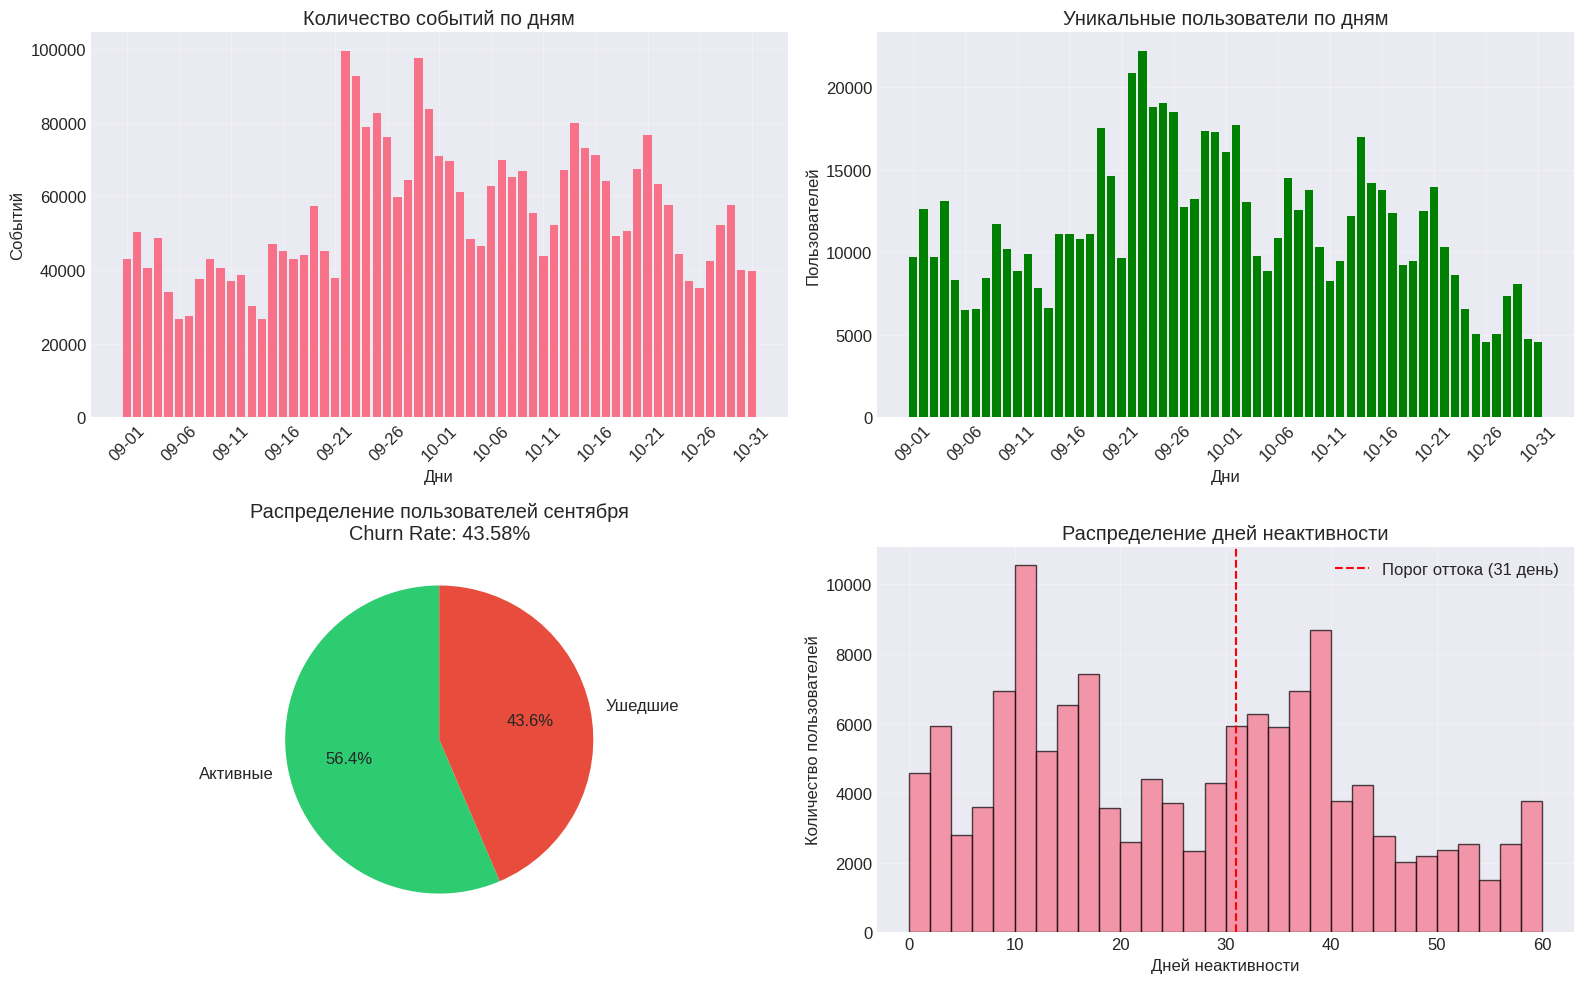

In [29]:
# 9. Визуализация
print("\nВИЗУАЛИЗАЦИЯ:")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. События по дням
axes[0, 0].bar(range(len(daily_stats)), daily_stats['Событий'])
axes[0, 0].set_title('Количество событий по дням')
axes[0, 0].set_xlabel('Дни')
axes[0, 0].set_ylabel('Событий')
axes[0, 0].set_xticks(range(0, len(daily_stats), 5))
axes[0, 0].set_xticklabels([d.strftime('%m-%d') for d in daily_stats.index[::5]], rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# 2. Уникальные пользователи по дням
axes[0, 1].bar(range(len(daily_stats)), daily_stats['Уникальных пользователей'], color='green')
axes[0, 1].set_title('Уникальные пользователи по дням')
axes[0, 1].set_xlabel('Дни')
axes[0, 1].set_ylabel('Пользователей')
axes[0, 1].set_xticks(range(0, len(daily_stats), 5))
axes[0, 1].set_xticklabels([d.strftime('%m-%d') for d in daily_stats.index[::5]], rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. Churn Rate
labels = ['Активные', 'Ушедшие']
sizes = [len(active_users), len(churned_users)]
colors = ['#2ecc71', '#e74c3c']

axes[1, 0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title(f'Распределение пользователей сентября\nChurn Rate: {len(churned_users)/len(sep_users)*100:.2f}%')

# 4. Распределение дней неактивности
axes[1, 1].hist(sep_days_inactive, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=31, color='red', linestyle='--', label='Порог оттока (31 день)')
axes[1, 1].set_title('Распределение дней неактивности')
axes[1, 1].set_xlabel('Дней неактивности')
axes[1, 1].set_ylabel('Количество пользователей')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Дополнительный анализ распределения

In [30]:
# Среднее количество событий на пользователя по месяцам
monthly_events_per_user = df_sep_oct.groupby(['month', 'device_id']).size().groupby('month').mean()
print(f"\nСреднее событий на пользователя:")
print(f"  Сентябрь: {monthly_events_per_user.get(9, 0):.1f}")
print(f"  Октябрь: {monthly_events_per_user.get(10, 0):.1f}")

# Распределение по дням недели в каждом месяце
df_sep_oct['weekday'] = df_sep_oct['event_dt'].dt.day_name()
monthly_weekday_dist = pd.crosstab(df_sep_oct['month'], df_sep_oct['weekday'])
print("\nРАСПРЕДЕЛЕНИЕ ПО ДНЯМ НЕДЕЛИ:")
print(monthly_weekday_dist)

# Анализ уникальных устройств
quantity1 = df1['device_id'].nunique()
quantity2 = df2['device_id'].nunique()
print(f'\nУникальных устройств в основном датасете: {quantity1}')
print(f'Уникальных устройств в словаре: {quantity2}')

# Анализ пропущенных значений
print("\nПропущенные значения в объединенном датафрейме:")
missing_values = df.isnull().sum()
missing_pct = (missing_values / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Количество': missing_values, 'Процент': missing_pct})
print(missing_df[missing_df['Количество'] > 0])

# Особый анализ пропусков в action
print("Детальный анализ пропусков в 'action':")
users_with_missing_action = df[df['action'].isnull()]['device_id'].nunique()
total_users = df['device_id'].nunique()
print(f"Пользователей с пропущенным action: {users_with_missing_action:,} из {total_users:,} ({users_with_missing_action/total_users*100:.1f}%)")


Среднее событий на пользователя:
  Сентябрь: 11.6
  Октябрь: 14.7

РАСПРЕДЕЛЕНИЕ ПО ДНЯМ НЕДЕЛИ:
weekday  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
month                                                                  
9        206230  324646    162106  156490    212516   314707     202985
10       264926  239503    178379  184594    305106   278295     330167

Уникальных устройств в основном датасете: 179976
Уникальных устройств в словаре: 180341

Пропущенные значения в объединенном датафрейме:
        Количество  Процент
action     1765376    52.53
age          17107     0.51
gender       21520     0.64
Детальный анализ пропусков в 'action':
Пользователей с пропущенным action: 169,395 из 179,976 (94.1%)


Создание дополнительных меток

In [31]:
# Создаем отдельные датафреймы для ушедших и активных пользователей
users_left = df[df['device_id'].isin(churned_users)]
df['is_churn'] = df['device_id'].isin(churned_users).astype(int)

# Определение is_finish (последняя нода в сессии)
df = df.sort_values(['device_id', 'session_id', 'event_dt'])

# Определяем последнее событие в каждой сессии
df['is_finish'] = 0
last_in_session = df.drop_duplicates(['device_id', 'session_id'], keep='last').index
df.loc[last_in_session, 'is_finish'] = 1

print(f"Количество is_finish = 1: {df['is_finish'].sum():,}")
print(f"Процент событий с is_finish = 1: {df['is_finish'].mean()*100:.2f}%")

# Разделение на ушедших и активных
df_left = df[df['is_churn'] == 1]
df_active = df[df['is_churn'] == 0]

print(f"\nДействий у ушедших пользователей: {len(df_left):,}")
print(f"Действий у активных пользователей: {len(df_active):,}")

Количество is_finish = 1: 1,002,265
Процент событий с is_finish = 1: 29.82%

Действий у ушедших пользователей: 393,779
Действий у активных пользователей: 2,966,871


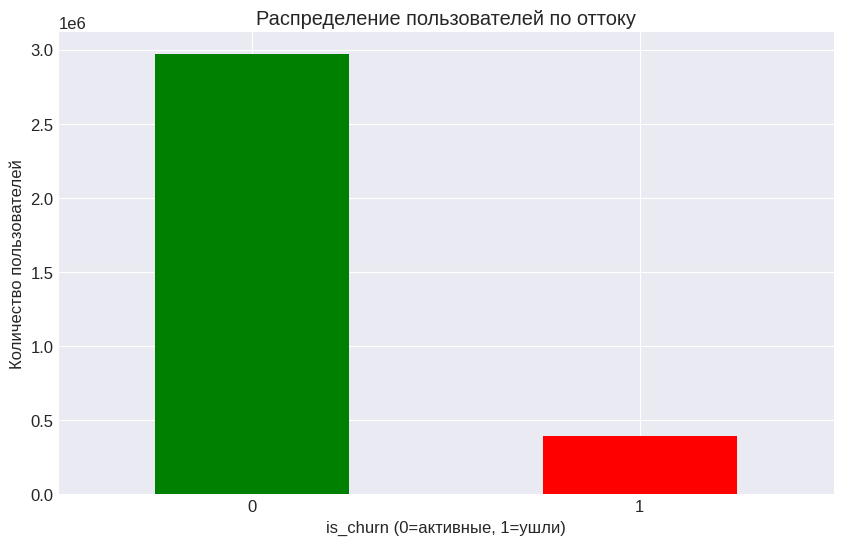


Столбцы в датафрейме: ['event_dt', 'screen', 'feature', 'action', 'device_id', 'session_id', 'device_vendor', 'device_model', 'device_type', 'os', 'age', 'gender', 'date', 'month', 'year', 'is_churn', 'is_finish']

Первые 3 строки датафрейма:
                        event_dt        screen                    feature  \
614672 2025-09-01 11:31:05+03:00           Еще            Открытие экрана   
614671 2025-09-01 11:31:06+03:00           Еще  Переход в раздел 'Заявки'   
614674 2025-09-01 11:31:06+03:00  Новая заявка            Открытие экрана   

                        action  device_id  is_churn  is_finish  
614672                     NaN          1         0          0  
614671  Тап на кнопку 'Заявки'          1         0          0  
614674                     NaN          1         0          0  


In [32]:
# Визуализация распределения оттока
plt.figure(figsize=(10, 6))
df['is_churn'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Распределение пользователей по оттоку')
plt.xlabel('is_churn (0=активные, 1=ушли)')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=0)
plt.show()

print(f"\nСтолбцы в датафрейме: {list(df.columns)}")
print("\nПервые 3 строки датафрейма:")
print(df[['event_dt', 'screen', 'feature', 'action',
          'device_id', 'is_churn', 'is_finish']].head(3))

АНАЛИЗ ПО ДЕМОГРАФИЧЕСКИМ ПРИЗНАКАМ

In [33]:
print("АНАЛИЗ ОТТОКА ПО ДЕМОГРАФИЧЕСКИМ ПРИЗНАКАМ")

# Создаем отдельный датафрейм для анализа сентябрьских пользователей
df_september = df_sep_oct[df_sep_oct['month'] == 9].copy()

# Убираем дубликаты по пользователям для демографического анализа
df_sep_users = df_september.drop_duplicates(subset=['device_id']).copy()

print(f"\nПользователей в сентябре для демографического анализа: {len(df_sep_users):,}")

АНАЛИЗ ОТТОКА ПО ДЕМОГРАФИЧЕСКИМ ПРИЗНАКАМ

Пользователей в сентябре для демографического анализа: 135,861


In [34]:
print("\nАНАЛИЗ ОТТОКА ПО ВОЗРАСТУ")

# ИСПРАВЛЕНО: Используем df вместо df_sep_oct
df_sep_users = df[df['month'].isin([9])].copy()
df_sep_users = df_sep_users.drop_duplicates(subset=['device_id'])

if 'age' in df_sep_users.columns and df_sep_users['age'].notna().sum() > 0:
    # Создаем возрастные группы
    bins = [18, 25, 35, 45, 55, 65, 101]
    labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

    df_sep_users['age_group'] = pd.cut(df_sep_users['age'], bins=bins, labels=labels, right=False)

    # Считаем статистику по возрастным группам
    age_churn_stats = df_sep_users.groupby('age_group').agg(
        total_users=('device_id', 'count'),
        churned_users=('is_churn', 'sum')
    )

    age_churn_stats['active_users'] = age_churn_stats['total_users'] - age_churn_stats['churned_users']
    age_churn_stats['churn_rate'] = (age_churn_stats['churned_users'] / age_churn_stats['total_users'] * 100).round(2)
    age_churn_stats['share_of_total'] = (age_churn_stats['total_users'] / len(df_sep_users) * 100).round(2)

    print("\nОтток по возрастным группам:")
    print(age_churn_stats[['total_users', 'churned_users', 'active_users', 'churn_rate', 'share_of_total']])

    # Находим группы с максимальным и минимальным оттоком
    if len(age_churn_stats) > 0:
        max_churn_age = age_churn_stats['churn_rate'].idxmax()
        min_churn_age = age_churn_stats['churn_rate'].idxmin()

        print(f"  • Самая проблемная группа: {max_churn_age} лет - {age_churn_stats.loc[max_churn_age, 'churn_rate']}% оттока")
        print(f"  • Наиболее лояльная группа: {min_churn_age} лет - {age_churn_stats.loc[min_churn_age, 'churn_rate']}% оттока")
        print(f"  • Средний отток по всем возрастам: {age_churn_stats['churn_rate'].mean():.2f}%")
else:
    print("Колонка 'age' отсутствует в данных или все значения пропущены")


АНАЛИЗ ОТТОКА ПО ВОЗРАСТУ

Отток по возрастным группам:
           total_users  churned_users  active_users  churn_rate  \
age_group                                                         
18-24             3756           2092          1664       55.70   
25-34            21527           9766         11761       45.37   
35-44            48004          21001         27003       43.75   
45-54            33816          14389         19427       42.55   
55-64            18134           7275         10859       40.12   
65+              10084           4215          5869       41.80   

           share_of_total  
age_group                  
18-24                2.76  
25-34               15.84  
35-44               35.33  
45-54               24.89  
55-64               13.35  
65+                  7.42  
  • Самая проблемная группа: 18-24 лет - 55.7% оттока
  • Наиболее лояльная группа: 55-64 лет - 40.12% оттока
  • Средний отток по всем возрастам: 44.88%


In [35]:
print("\nАНАЛИЗ ОТТОКА ПО ПОЛУ")


if 'gender' in df_sep_users.columns and df_sep_users['gender'].notna().sum() > 0:
    # Анализируем распределение по полу
    gender_churn_stats = df_sep_users.groupby('gender').agg(
        total_users=('device_id', 'count'),
        churned_users=('is_churn', 'sum')
    )

    gender_churn_stats['active_users'] = gender_churn_stats['total_users'] - gender_churn_stats['churned_users']
    gender_churn_stats['churn_rate'] = (gender_churn_stats['churned_users'] / gender_churn_stats['total_users'] * 100).round(2)
    gender_churn_stats['share_of_total'] = (gender_churn_stats['total_users'] / len(df_sep_users) * 100).round(2)

    print("\nОтток по полу:")
    print(gender_churn_stats[['total_users', 'churned_users', 'active_users', 'churn_rate', 'share_of_total']])

    # Сравниваем мужчин и женщин
    if 'М' in gender_churn_stats.index and 'Ж' in gender_churn_stats.index:
        men_churn = gender_churn_stats.loc['М', 'churn_rate']
        women_churn = gender_churn_stats.loc['Ж', 'churn_rate']
        diff = men_churn - women_churn

        print(f"\nСРАВНЕНИЕ ПО ПОЛУ:")
        print(f"  • Мужчины: {men_churn}% оттока")
        print(f"  • Женщины: {women_churn}% оттока")
        print(f"  • Разница: {abs(diff):.2f}% ({'мужчины уходят чаще' if diff > 0 else 'женщины уходят чаще' if diff < 0 else 'одинаковый отток'})")

    # Проверяем наличие других значений
    other_genders = [g for g in gender_churn_stats.index if g not in ['М', 'Ж']]
    if other_genders:
        print(f"\nОбнаружены другие значения в поле gender: {other_genders}")
else:
    print("Колонка 'gender' отсутствует в данных или все значения пропущены")


АНАЛИЗ ОТТОКА ПО ПОЛУ

Отток по полу:
        total_users  churned_users  active_users  churn_rate  share_of_total
gender                                                                      
Ж             75279          32677         42602       43.41           55.41
М             59749          25900         33849       43.35           43.98

СРАВНЕНИЕ ПО ПОЛУ:
  • Мужчины: 43.35% оттока
  • Женщины: 43.41% оттока
  • Разница: 0.06% (женщины уходят чаще)


In [36]:
print("\nАНАЛИЗ: ВОЗРАСТ + ПОЛ")


if 'age' in df_sep_users.columns and 'gender' in df_sep_users.columns:
    # Создаем сводную таблицу
    pivot_data = pd.pivot_table(
        df_sep_users,
        index='age_group',
        columns='gender',
        values='is_churn',
        aggfunc=['mean', 'count']
    )

    # Переименовываем колонки для читаемости
    pivot_data.columns = ['_'.join(col).strip() for col in pivot_data.columns.values]

    print("\nОтток по комбинации возраст-пол (среднее значение):")

    # Извлекаем данные для оттока
    churn_cols = [col for col in pivot_data.columns if 'mean' in col]
    for col in churn_cols:
        pivot_data[col] = (pivot_data[col] * 100).round(1)

    print(pivot_data[churn_cols])

    # Находим самую проблемную комбинацию
    if not pivot_data[churn_cols].empty:
        max_churn_value = pivot_data[churn_cols].max().max()
        max_churn_idx = pivot_data[churn_cols].stack().idxmax()

        print(f"  • Возраст: {max_churn_idx[0]}, Пол: {max_churn_idx[1]}")
        print(f"  • Отток: {max_churn_value}%")
else:
    print("Для комбинированного анализа нужны колонки 'age' и 'gender'")


АНАЛИЗ: ВОЗРАСТ + ПОЛ

Отток по комбинации возраст-пол (среднее значение):
           mean_Ж  mean_М
age_group                
18-24        54.4    57.3
25-34        44.6    46.5
35-44        44.3    43.1
45-54        42.0    43.1
55-64        40.2    40.0
65+          43.0    39.8
  • Возраст: 18-24, Пол: mean_М
  • Отток: 57.3%



ВИЗУАЛИЗАЦИЯ ДЕМОГРАФИЧЕСКОГО АНАЛИЗА


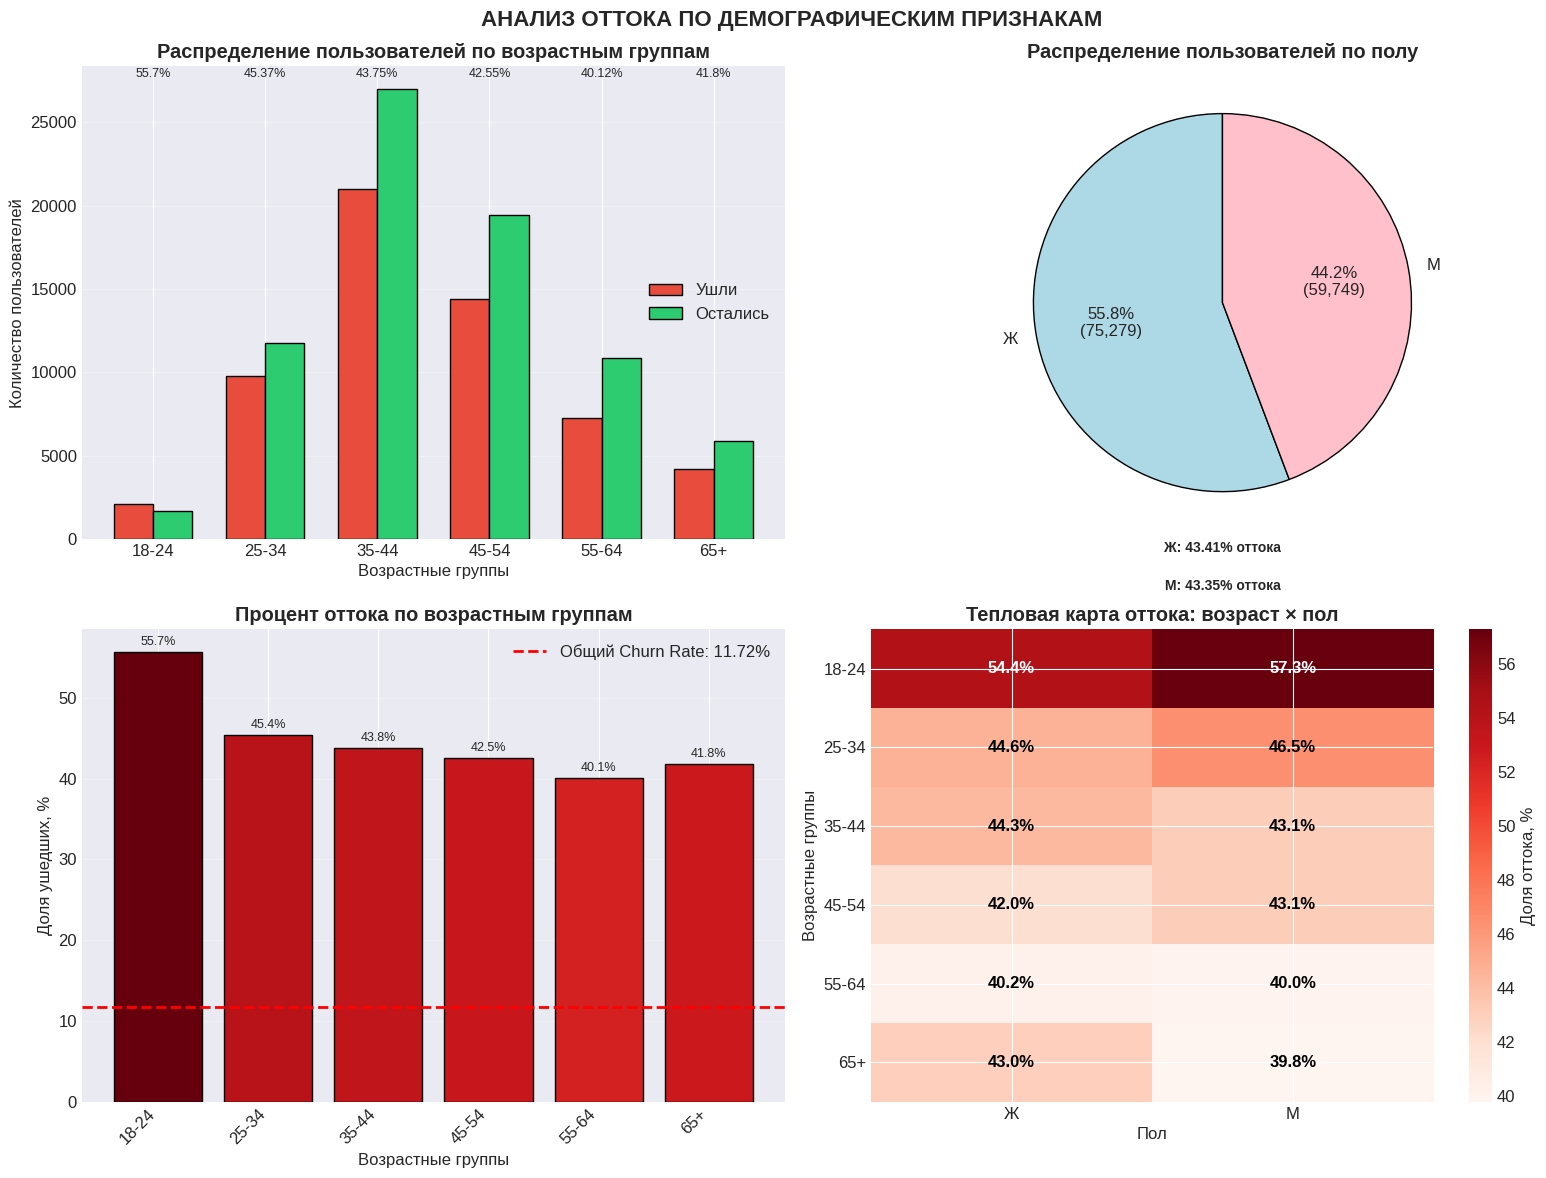

In [37]:
print("\nВИЗУАЛИЗАЦИЯ ДЕМОГРАФИЧЕСКОГО АНАЛИЗА")


# Создаем новую фигуру для демографических графиков
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('АНАЛИЗ ОТТОКА ПО ДЕМОГРАФИЧЕСКИМ ПРИЗНАКАМ', fontsize=16, fontweight='bold')

# График 1: Отток по возрастным группам (если есть данные)
if 'age' in df_sep_users.columns and 'age_churn_stats' in locals() and len(age_churn_stats) > 0:
    ax1 = axes[0, 0]
    x_pos = np.arange(len(age_churn_stats.index))

    # Столбчатая диаграмма с двумя столбцами
    width = 0.35
    bars1 = ax1.bar(x_pos - width/2, age_churn_stats['churned_users'], width,
                    label='Ушли', color='#e74c3c', edgecolor='black')
    bars2 = ax1.bar(x_pos + width/2, age_churn_stats['active_users'], width,
                    label='Остались', color='#2ecc71', edgecolor='black')

    ax1.set_title('Распределение пользователей по возрастным группам', fontweight='bold')
    ax1.set_xlabel('Возрастные группы')
    ax1.set_ylabel('Количество пользователей')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(age_churn_stats.index)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')

    # Добавляем значения оттока на график
    for i, (churn_rate, total) in enumerate(zip(age_churn_stats['churn_rate'], age_churn_stats['total_users'])):
        ax1.text(i, max(age_churn_stats['churned_users'].max(), age_churn_stats['active_users'].max()) * 1.02,
                f'{churn_rate}%', ha='center', va='bottom', fontsize=9)
else:
    axes[0, 0].text(0.5, 0.5, 'Нет данных по возрасту', ha='center', va='center', fontsize=12)
    axes[0, 0].set_title('Отток по возрастным группам', fontweight='bold')

# График 2: Отток по полу (если есть данные)
if 'gender' in df_sep_users.columns and 'gender_churn_stats' in locals() and len(gender_churn_stats) > 0:
    ax2 = axes[0, 1]

    # Фильтруем только мужчин и женщин для графика
    plot_genders = [g for g in gender_churn_stats.index if g in ['М', 'Ж']]
    if plot_genders:
        plot_data = gender_churn_stats.loc[plot_genders]

        # Круговая диаграмма для распределения по полу
        wedges, texts, autotexts = ax2.pie(
            plot_data['total_users'],
            labels=plot_data.index,
            autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*plot_data["total_users"].sum()):,})',
            colors=['lightblue', 'pink'],
            startangle=90,
            wedgeprops={'edgecolor': 'black'}
        )

        ax2.set_title('Распределение пользователей по полу', fontweight='bold')

        # Добавляем аннотации с процентом оттока
        for i, gender in enumerate(plot_data.index):
            churn_rate = plot_data.loc[gender, 'churn_rate']
            ax2.text(0, -1.3 - i*0.2, f'{gender}: {churn_rate}% оттока',
                    ha='center', va='center', fontsize=10, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'Нет данных по полу', ha='center', va='center', fontsize=12)
else:
    axes[0, 1].text(0.5, 0.5, 'Нет данных по полу', ha='center', va='center', fontsize=12)
    axes[0, 1].set_title('Распределение по полу', fontweight='bold')

# График 3: Процент оттока по возрастным группам
if 'age' in df_sep_users.columns and 'age_churn_stats' in locals() and len(age_churn_stats) > 0:
    ax3 = axes[1, 0]

    bars = ax3.bar(age_churn_stats.index, age_churn_stats['churn_rate'],
                   color=plt.cm.Reds(age_churn_stats['churn_rate'] / age_churn_stats['churn_rate'].max()),
                   edgecolor='black')

    ax3.axhline(y=df['is_churn'].mean()*100, color='red', linestyle='--', linewidth=2,
                label=f'Общий Churn Rate: {df["is_churn"].mean()*100:.2f}%')

    ax3.set_title('Процент оттока по возрастным группам', fontweight='bold')
    ax3.set_xlabel('Возрастные группы')
    ax3.set_ylabel('Доля ушедших, %')
    ax3.set_xticklabels(age_churn_stats.index, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')

    # Добавляем значения на столбцы
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
else:
    axes[1, 0].text(0.5, 0.5, 'Нет данных по возрасту', ha='center', va='center', fontsize=12)
    axes[1, 0].set_title('Процент оттока по возрастам', fontweight='bold')

# График 4: Heatmap возраст-пол (если есть данные)
if 'age' in df_sep_users.columns and 'gender' in df_sep_users.columns and 'pivot_data' in locals() and 'churn_cols' in locals():
    ax4 = axes[1, 1]

    # Подготовка данных для heatmap
    heatmap_data = pivot_data[churn_cols] if churn_cols else None

    if heatmap_data is not None and not heatmap_data.empty:
        # Создаем heatmap
        im = ax4.imshow(heatmap_data.values, cmap='Reds', aspect='auto')

        ax4.set_title('Тепловая карта оттока: возраст × пол', fontweight='bold')
        ax4.set_xlabel('Пол')
        ax4.set_ylabel('Возрастные группы')
        ax4.set_xticks(np.arange(len(heatmap_data.columns)))
        ax4.set_yticks(np.arange(len(heatmap_data.index)))
        ax4.set_xticklabels([col.split('_')[1] for col in heatmap_data.columns])
        ax4.set_yticklabels(heatmap_data.index)

        # Добавляем цветовую шкалу
        plt.colorbar(im, ax=ax4, label='Доля оттока, %')

        # Добавляем значения в ячейки
        for i in range(len(heatmap_data.index)):
            for j in range(len(heatmap_data.columns)):
                value = heatmap_data.iloc[i, j]
                if not pd.isna(value):
                    text_color = 'white' if value > 50 else 'black'
                    ax4.text(j, i, f'{value:.1f}%',
                            ha='center', va='center',
                            color=text_color, fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'Нет данных для heatmap', ha='center', va='center', fontsize=12)
        ax4.set_title('Тепловая карта: возраст × пол', fontweight='bold')
else:
    axes[1, 1].text(0.5, 0.5, 'Нет данных для комбинированного анализа', ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Тепловая карта: возраст × пол', fontweight='bold')

plt.tight_layout()
plt.show()

In [39]:
print("СВОДНЫЕ ВЫВОДЫ ПО ДЕМОГРАФИЧЕСКОМУ АНАЛИЗУ")

print(f"  • Всего пользователей в сентябре: {len(sep_users):,}")
print(f"  • Ушедших пользователей: {len(churned_users):,}")
print(f"  • Активных пользователей: {len(active_users):,}")
print(f"  • Общий Churn Rate: {len(churned_users)/len(sep_users)*100:.2f}%")

print(f"\nКЛЮЧЕВЫЕ НАХОДКИ:")

if 'age' in df_sep_users.columns and 'age_churn_stats' in locals():
    print(f"  1. Возрастные группы:")
    for age_group in age_churn_stats.index:
        churn_rate = age_churn_stats.loc[age_group, 'churn_rate']
        share = age_churn_stats.loc[age_group, 'share_of_total']
        status = "ВЫСОКИЙ ОТТОК" if churn_rate > 50 else "СРЕДНИЙ ОТТОК" if churn_rate > 40 else "НИЗКИЙ ОТТОК"
        print(f"     • {age_group} лет: {churn_rate}% оттока ({share}% от всех пользователей) - {status}")

if 'gender' in df_sep_users.columns and 'gender_churn_stats' in locals():
    print(f"\n  2. Гендерный анализ:")
    for gender in gender_churn_stats.index:
        if gender in ['М', 'Ж']:
            churn_rate = gender_churn_stats.loc[gender, 'churn_rate']
            share = gender_churn_stats.loc[gender, 'share_of_total']
            gender_name = "Мужчины" if gender == 'М' else "Женщины"
            print(f"     • {gender_name}: {churn_rate}% оттока ({share}% от всех пользователей)")


СВОДНЫЕ ВЫВОДЫ ПО ДЕМОГРАФИЧЕСКОМУ АНАЛИЗУ
  • Всего пользователей в сентябре: 135,861
  • Ушедших пользователей: 59,203
  • Активных пользователей: 76,658
  • Общий Churn Rate: 43.58%

КЛЮЧЕВЫЕ НАХОДКИ:
  1. Возрастные группы:
     • 18-24 лет: 55.7% оттока (2.76% от всех пользователей) - ВЫСОКИЙ ОТТОК
     • 25-34 лет: 45.37% оттока (15.84% от всех пользователей) - СРЕДНИЙ ОТТОК
     • 35-44 лет: 43.75% оттока (35.33% от всех пользователей) - СРЕДНИЙ ОТТОК
     • 45-54 лет: 42.55% оттока (24.89% от всех пользователей) - СРЕДНИЙ ОТТОК
     • 55-64 лет: 40.12% оттока (13.35% от всех пользователей) - СРЕДНИЙ ОТТОК
     • 65+ лет: 41.8% оттока (7.42% от всех пользователей) - СРЕДНИЙ ОТТОК

  2. Гендерный анализ:
     • Женщины: 43.41% оттока (55.41% от всех пользователей)
     • Мужчины: 43.35% оттока (43.98% от всех пользователей)


Анализ технических факторов оттока

In [40]:
print("\nАНАЛИЗ ТЕХНИЧЕСКИХ ФАКТОРОВ ОТТОКА")

# Отток по типу устройства
print("Отток по типу устройства:")

left_counts_device = df_left['device_type'].value_counts()
active_counts_device = df_active['device_type'].value_counts()
total_counts_device = left_counts_device.add(active_counts_device, fill_value=0)
share_left_device = (left_counts_device / total_counts_device * 100).round(2)

device_churn_df = pd.DataFrame({
    'Ушли': left_counts_device,
    'Активны': active_counts_device,
    'Всего': total_counts_device,
    'Доля ушедших, %': share_left_device
})
print(device_churn_df)

# Отток по производителю устройств
print("\nОтток по производителю устройств (топ-10):")

left_counts_vendor = df_left['device_vendor'].value_counts()
active_counts_vendor = df_active['device_vendor'].value_counts()
total_counts_vendor = left_counts_vendor.add(active_counts_vendor, fill_value=0)
share_left_vendor = (left_counts_vendor / total_counts_vendor * 100).round(2)

vendor_churn_df = pd.DataFrame({
    'Ушли': left_counts_vendor,
    'Активны': active_counts_vendor,
    'Всего': total_counts_vendor,
    'Доля ушедших, %': share_left_vendor
}).sort_values('Всего', ascending=False)

print(vendor_churn_df.head(10))


АНАЛИЗ ТЕХНИЧЕСКИХ ФАКТОРОВ ОТТОКА
Отток по типу устройства:
               Ушли  Активны    Всего  Доля ушедших, %
device_type                                           
phone        388849  2938838  3327687            11.69
tablet         4930    28033    32963            14.96

Отток по производителю устройств (топ-10):
                   Ушли    Активны      Всего  Доля ушедших, %
device_vendor                                                 
Apple          190190.0  1231612.0  1421802.0            13.38
Samsung         66011.0   555348.0   621359.0            10.62
Redmi           28532.0   286139.0   314671.0             9.07
Huawei          20820.0   177545.0   198365.0            10.50
Xiaomi          21479.0   168034.0   189513.0            11.33
POCO            13451.0   122309.0   135760.0             9.91
Realme          11828.0   103896.0   115724.0            10.22
Honor            9897.0    76634.0    86531.0            11.44
Tecno            5844.0    53667.0    59511.

Анализ проблемных моделей устройств

In [41]:
# Анализ проблемных моделей устройств
print("\nПРОБЛЕМНЫЕ МОДЕЛИ УСТРОЙСТВ С ВЫСОКИМ ОТТОКОМ:")

# Модели с достаточным количеством пользователей
model_stats = df.groupby('device_model').agg({
    'device_id': 'nunique',
    'is_churn': 'mean'
}).rename(columns={'device_id': 'users', 'is_churn': 'churn_rate'})

# Фильтруем модели с минимум 50 пользователями
min_users = 50
significant_models = model_stats[model_stats['users'] >= min_users]

if len(significant_models) > 0:
    # Находим модели с аномально высоким оттоком (верхний квартиль)
    high_churn_threshold = significant_models['churn_rate'].quantile(0.75)
    high_churn_models = significant_models[significant_models['churn_rate'] > high_churn_threshold]

    high_churn_models = high_churn_models.sort_values('churn_rate', ascending=False)

    print(f"\nНайдено {len(high_churn_models)} проблемных моделей (отток > {high_churn_threshold:.1%}):")
    print(f"Минимальное количество пользователей для анализа: {min_users}")

    for model, row in high_churn_models.head(10).iterrows():
        print(f"  • {model}: {row['churn_rate']:.1%} оттока ({row['users']} пользователей)")
else:
    print("Недостаточно данных для анализа моделей устройств")


ПРОБЛЕМНЫЕ МОДЕЛИ УСТРОЙСТВ С ВЫСОКИМ ОТТОКОМ:

Найдено 97 проблемных моделей (отток > 13.4%):
Минимальное количество пользователей для анализа: 50
  • Chromebook Pixel (2015): 53.2% оттока (81.0 пользователей)
  • Pixel 5: 34.5% оттока (76.0 пользователей)
  • Galaxy S8: 34.1% оттока (69.0 пользователей)
  • OnePlus 9 5G: 26.4% оттока (57.0 пользователей)
  • V40: 26.4% оттока (66.0 пользователей)
  • MI 9 SE: 26.3% оттока (67.0 пользователей)
  • OnePlus 8 Pro: 25.4% оттока (63.0 пользователей)
  • OnePlus 9R: 25.3% оттока (100.0 пользователей)
  • Pixel 8: 23.7% оттока (88.0 пользователей)
  • ELS-NX9: 23.2% оттока (61.0 пользователей)


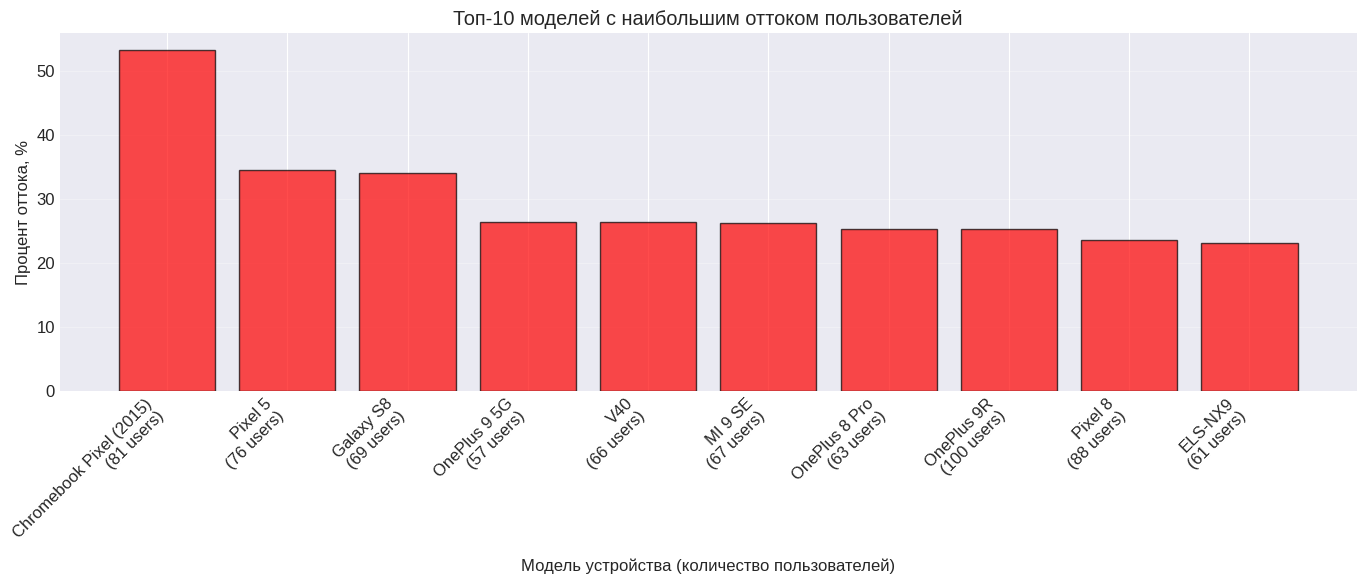

In [42]:
# Визуализация топ-10 проблемных моделей
if 'high_churn_models' in locals() and len(high_churn_models) > 0:
    plt.figure(figsize=(14, 6))
    top_problem_models = high_churn_models.head(10)

    # Создаем подписи для оси X (модель + количество пользователей)
    x_labels = [f"{idx}\n({int(row['users'])} users)" for idx, row in top_problem_models.iterrows()]

    x_positions = np.arange(len(top_problem_models))
    plt.bar(x_positions, top_problem_models['churn_rate'] * 100,
            color='red', alpha=0.7, edgecolor='black')

    plt.xticks(x_positions, x_labels, rotation=45, ha='right')
    plt.ylabel('Процент оттока, %')
    plt.xlabel('Модель устройства (количество пользователей)')
    plt.title('Топ-10 моделей с наибольшим оттоком пользователей')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

Поведенческий анализ - частота использования

In [43]:
print("\nПОВЕДЕНЧЕСКИЙ АНАЛИЗ ПОЛЬЗОВАТЕЛЕЙ")

# 1. Анализ частоты использования
print("1. АНАЛИЗ ЧАСТОТЫ ИСПОЛЬЗОВАНИЯ:")

# Количество сессий на пользователя
sessions_per_user_left = df_left.groupby('device_id')['session_id'].nunique()
sessions_per_user_active = df_active.groupby('device_id')['session_id'].nunique()

print(f"Среднее число сессий:")
print(f"  • Ушедшие: {sessions_per_user_left.mean():.1f} (±{sessions_per_user_left.std():.1f})")
print(f"  • Активные: {sessions_per_user_active.mean():.1f} (±{sessions_per_user_active.std():.1f})")
print(f"  • Разница: {sessions_per_user_active.mean() - sessions_per_user_left.mean():.1f} сессий")

# Количество действий на пользователя
actions_per_user_left = df_left.groupby('device_id').size()
actions_per_user_active = df_active.groupby('device_id').size()

print(f"\nСреднее число действий:")
print(f"  • Ушедшие: {actions_per_user_left.mean():.1f} (±{actions_per_user_left.std():.1f})")
print(f"  • Активные: {actions_per_user_active.mean():.1f} (±{actions_per_user_active.std():.1f})")
print(f"  • Разница: {actions_per_user_active.mean() - actions_per_user_left.mean():.1f} действий")


ПОВЕДЕНЧЕСКИЙ АНАЛИЗ ПОЛЬЗОВАТЕЛЕЙ
1. АНАЛИЗ ЧАСТОТЫ ИСПОЛЬЗОВАНИЯ:
Среднее число сессий:
  • Ушедшие: 2.2 (±2.5)
  • Активные: 7.2 (±14.1)
  • Разница: 5.0 сессий

Среднее число действий:
  • Ушедшие: 6.7 (±10.2)
  • Активные: 24.6 (±54.2)
  • Разница: 17.9 действий


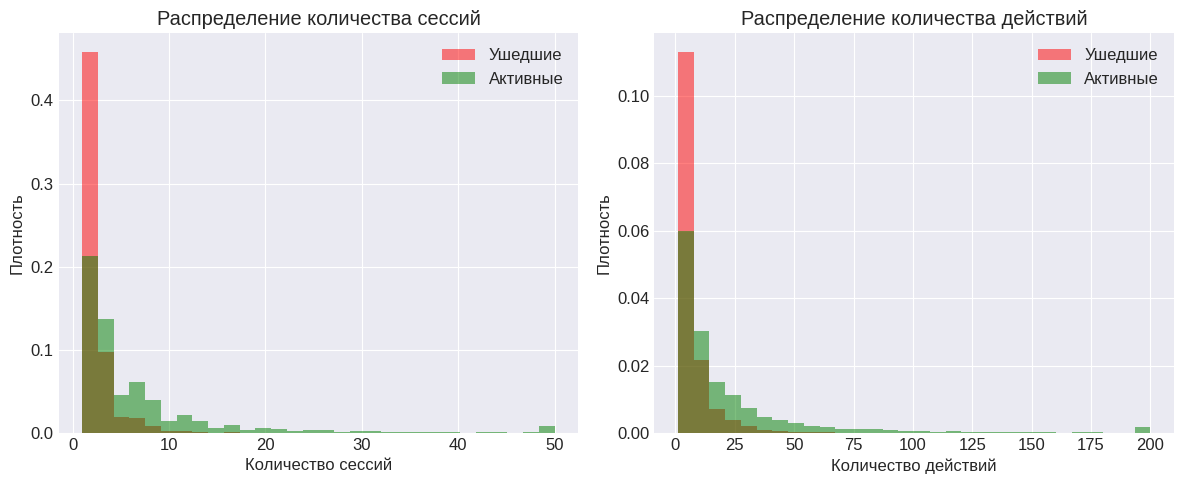

In [44]:
# Визуализация распределения сессий
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(sessions_per_user_left.clip(0, 50), bins=30, alpha=0.5, label='Ушедшие', density=True, color='red')
plt.hist(sessions_per_user_active.clip(0, 50), bins=30, alpha=0.5, label='Активные', density=True, color='green')
plt.xlabel('Количество сессий')
plt.ylabel('Плотность')
plt.title('Распределение количества сессий')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(actions_per_user_left.clip(0, 200), bins=30, alpha=0.5, label='Ушедшие', density=True, color='red')
plt.hist(actions_per_user_active.clip(0, 200), bins=30, alpha=0.5, label='Активные', density=True, color='green')
plt.xlabel('Количество действий')
plt.ylabel('Плотность')
plt.title('Распределение количества действий')
plt.legend()

plt.tight_layout()
plt.show()

Анализ времени жизни пользователей

In [45]:
# 2. Анализ времени жизни пользователей
print("\n2. АНАЛИЗ ВРЕМЕНИ ЖИЗНИ ПОЛЬЗОВАТЕЛЕЙ:")

# Время жизни пользователей
user_activity = df.groupby('device_id')['event_dt'].agg(['min', 'max']).rename(
    columns={'min': 'first_event', 'max': 'last_event'})
user_activity['lifetime_days'] = (user_activity['last_event'] - user_activity['first_event']).dt.days
user_activity['is_churn'] = user_activity.index.isin(churned_users).astype(int)

churned_lifetime = user_activity[user_activity['is_churn'] == 1]['lifetime_days']
active_lifetime = user_activity[user_activity['is_churn'] == 0]['lifetime_days']

print(f"Среднее время жизни:")
print(f"  • Ушедшие: {churned_lifetime.mean():.1f} дней (±{churned_lifetime.std():.1f})")
print(f"  • Активные: {active_lifetime.mean():.1f} дней (±{active_lifetime.std():.1f})")
print(f"  • Отношение: {active_lifetime.mean()/max(churned_lifetime.mean(), 0.1):.1f}x")


2. АНАЛИЗ ВРЕМЕНИ ЖИЗНИ ПОЛЬЗОВАТЕЛЕЙ:
Среднее время жизни:
  • Ушедшие: 3.5 дней (±6.6)
  • Активные: 22.5 дней (±18.0)
  • Отношение: 6.4x


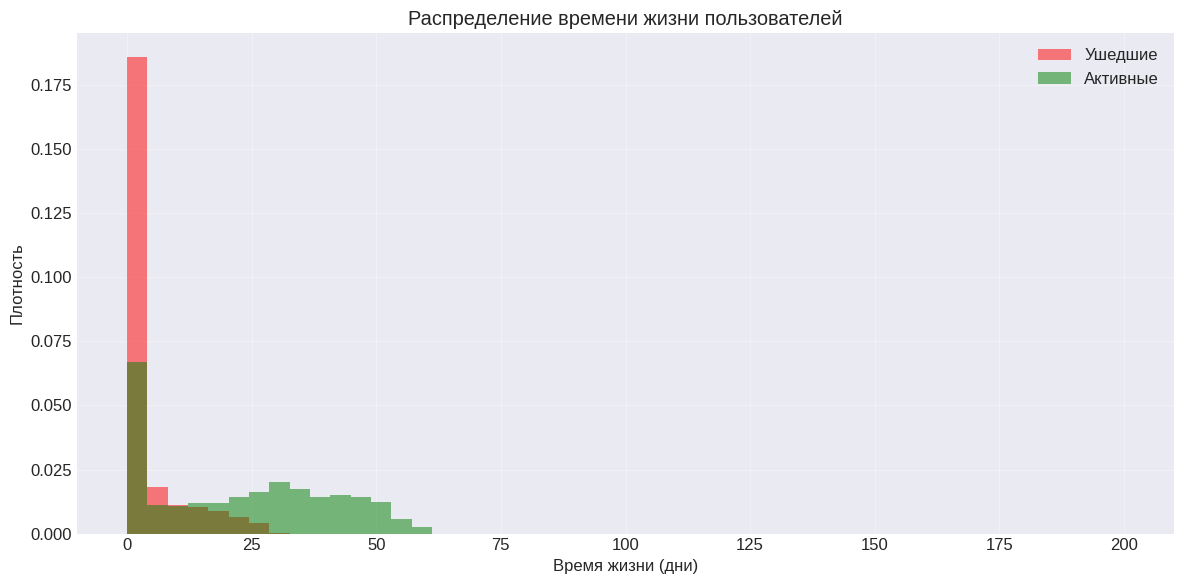

In [46]:
# Визуализация времени жизни
plt.figure(figsize=(12, 6))
bins = np.linspace(0, 200, 50)

plt.hist(churned_lifetime.clip(0, 200), bins=bins, alpha=0.5,
         label='Ушедшие', density=True, color='red')
plt.hist(active_lifetime.clip(0, 200), bins=bins, alpha=0.5,
         label='Активные', density=True, color='green')
plt.xlabel('Время жизни (дни)')
plt.ylabel('Плотность')
plt.title('Распределение времени жизни пользователей')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Анализ активности по времени суток и дням недели


3. АНАЛИЗ АКТИВНОСТИ ПО ВРЕМЕНИ:


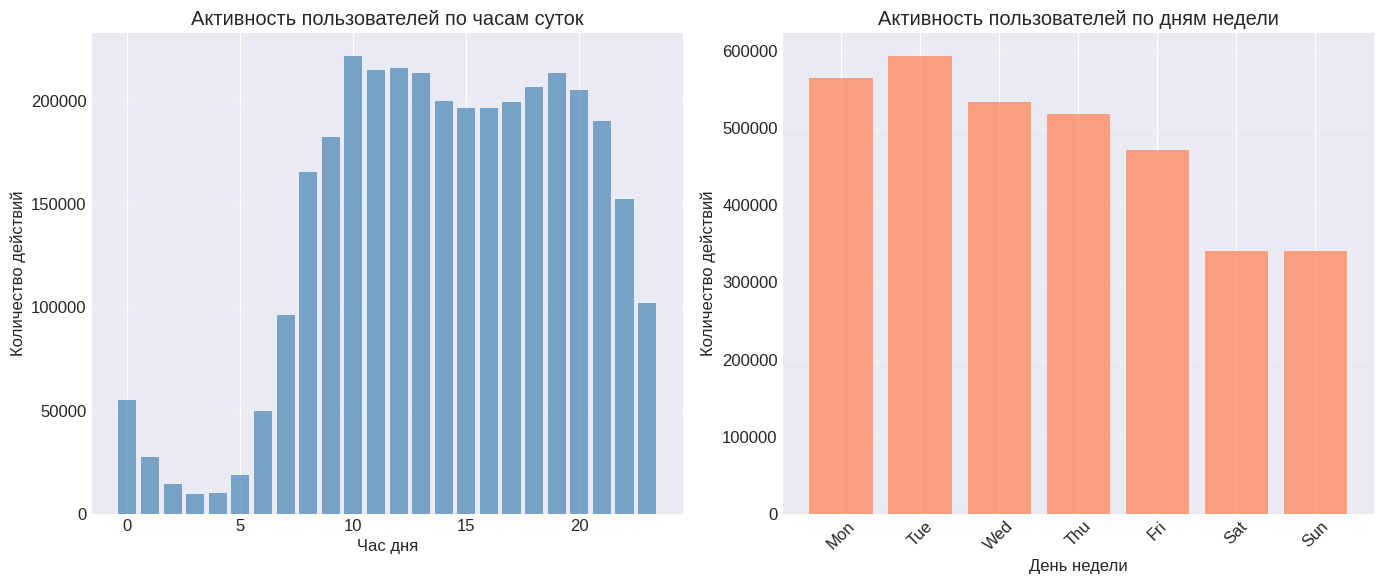

Пиковые часы активности: 10ч (221,756 действий)
Самый активный день: Tuesday (593,002 действий)


In [50]:
# 3. Анализ активности по времени суток и дням недели
print("\n3. АНАЛИЗ АКТИВНОСТИ ПО ВРЕМЕНИ:")

df['hour'] = df['event_dt'].dt.hour
df['day_of_week'] = df['event_dt'].dt.day_name()
df['day_of_week_num'] = df['event_dt'].dt.dayofweek

# Активность по часам суток
hourly_activity = df.groupby('hour').size()

# Активность по дням недели
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_activity = df.groupby('day_of_week').size().reindex(days_order)

# Визуализация
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(hourly_activity.index, hourly_activity.values, color='steelblue', alpha=0.7)
plt.xlabel('Час дня')
plt.ylabel('Количество действий')
plt.title('Активность пользователей по часам суток')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
bars = plt.bar(range(len(daily_activity)), daily_activity.values, color='coral', alpha=0.7)
plt.xticks(range(len(daily_activity)), [day[:3] for day in daily_activity.index], rotation=45)
plt.xlabel('День недели')
plt.ylabel('Количество действий')
plt.title('Активность пользователей по дням недели')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Пиковые часы активности: {hourly_activity.idxmax()}ч ({hourly_activity.max():,} действий)")
print(f"Самый активный день: {daily_activity.idxmax()} ({daily_activity.max():,} действий)")

Анализ пользовательских путей и критических точек

In [48]:
print("\nАНАЛИЗ ПОЛЬЗОВАТЕЛЬСКИХ ПУТЕЙ И КРИТИЧЕСКИХ ТОЧЕК")

# Анализ последних действий перед уходом
print("\n1. АНАЛИЗ ПОСЛЕДНИХ ДЕЙСТВИЙ ПЕРЕД УХОДОМ:")

# Сортируем данные ушедших пользователей
df_sorted = df.sort_values(['device_id', 'session_id', 'event_dt'])

# Анализируем последние N действий перед уходом
last_n_actions = 3
last_actions = df_sorted[df_sorted['is_churn'] == 1].groupby('device_id').tail(last_n_actions)

print(f"\nТоп screen в последних {last_n_actions} действиях перед уходом:")
top_last_screens = last_actions['screen'].value_counts().head(10)
for screen, count in top_last_screens.items():
    percentage = count / len(last_actions) * 100
    print(f"  • {screen:30s}: {count:6,} ({percentage:.1f}%)")

print(f"\nТоп feature в последних {last_n_actions} действиях перед уходом:")
top_last_features = last_actions['feature'].value_counts().head(10)
for feature, count in top_last_features.items():
    percentage = count / len(last_actions) * 100
    print(f"  • {feature:30s}: {count:6,} ({percentage:.1f}%)")

# Для node_id убедитесь, что такая колонка существует в ваших данных
if 'node_id' in last_actions.columns:
    print(f"\nТоп node_id в последних {last_n_actions} действиях перед уходом:")
    top_last_nodes = last_actions['node_id'].value_counts().head(10)
    for node, count in top_last_nodes.items():
        percentage = count / len(last_actions) * 100
        print(f"  • {node:40s}: {count:6,} ({percentage:.1f}%)")


АНАЛИЗ ПОЛЬЗОВАТЕЛЬСКИХ ПУТЕЙ И КРИТИЧЕСКИХ ТОЧЕК

1. АНАЛИЗ ПОСЛЕДНИХ ДЕЙСТВИЙ ПЕРЕД УХОДОМ:

Топ screen в последних 3 действиях перед уходом:
  • Еще                           : 95,014 (67.9%)
  • Важное                        : 21,158 (15.1%)
  • Новая заявка                  : 15,570 (11.1%)
  • Услуги                        :  2,787 (2.0%)
  • Мои баллы                     :  2,418 (1.7%)
  • Новое ОСС                     :  1,160 (0.8%)
  • Объявления                    :    935 (0.7%)
  • Связаться с владельцем ТС     :    910 (0.7%)
  • Гостевой доступ               :     13 (0.0%)
  • Заявки                        :      7 (0.0%)

Топ feature в последних 3 действиях перед уходом:
  • Открытие экрана               : 75,847 (54.2%)
  • Просмотр уведомления          : 21,158 (15.1%)
  • Переход в раздел 'Опросы и собрания собственников': 12,051 (8.6%)
  • Возврат на предыдущий этап    :  3,423 (2.4%)
  • Переход в раздел 'Приборы учета':  3,151 (2.3%)
  • Переход в раздел 'Заявк

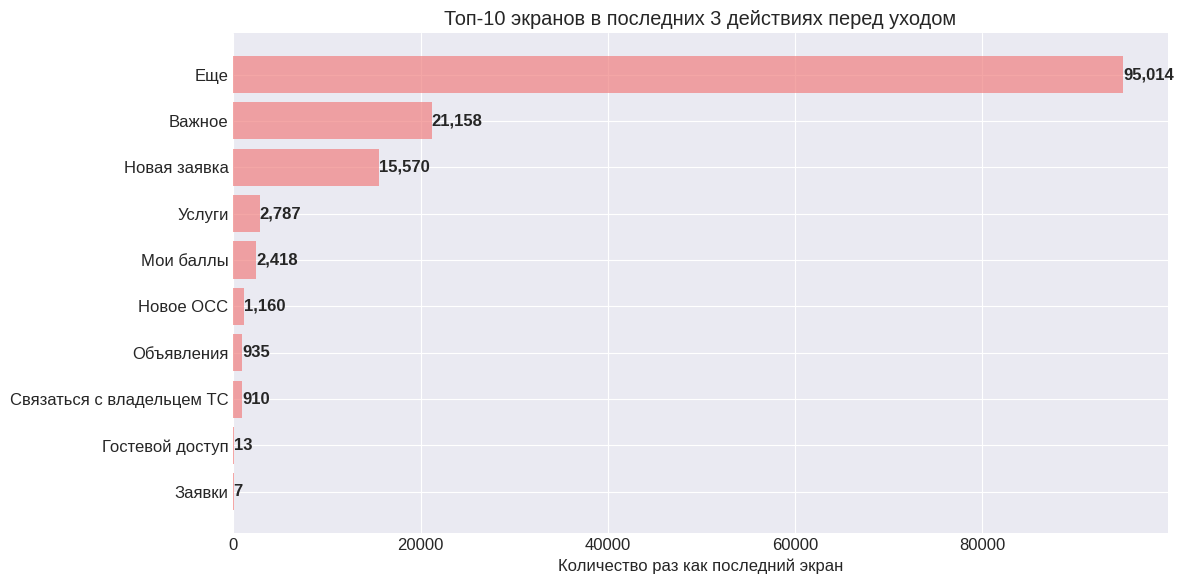

In [51]:
# Визуализация топ экранов перед уходом
plt.figure(figsize=(12, 6))
top_screens = last_actions['screen'].value_counts().head(10)

bars = plt.barh(range(len(top_screens)), top_screens.values, color='lightcoral', alpha=0.7)
plt.yticks(range(len(top_screens)), top_screens.index)
plt.xlabel('Количество раз как последний экран')
plt.title(f'Топ-10 экранов в последних {last_n_actions} действиях перед уходом')
plt.gca().invert_yaxis()

# Добавляем значения на столбцы
for i, (idx, value) in enumerate(top_screens.items()):
    plt.text(value + 0.1, i, f"{value:,}", va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [54]:
# 2. Анализ is_finish по разным группам
print("\n2. АНАЛИЗ ЗАВЕРШЕНИЯ СЕССИЙ (is_finish):")

# Анализ по screen (экранам)
print("\nАнализ завершения сессий по экранам (screen):")

screen_finish_stats = df.groupby('screen').agg({
    'is_finish': ['mean', 'count', 'sum']
}).round(3)

screen_finish_stats.columns = ['finish_rate', 'total_visits', 'finish_count']
screen_finish_stats = screen_finish_stats.sort_values('finish_rate', ascending=False)

print("\nТоп-10 экранов с наибольшим процентом завершений сессий:")
top_finish_screens = screen_finish_stats[screen_finish_stats['total_visits'] > 100].head(10)
for screen, row in top_finish_screens.iterrows():
    print(f"  • {screen:40s}: {row['finish_rate']:.1%} ({row['finish_count']:,}/{row['total_visits']:,})")

print("\nТоп-10 экранов с наименьшим процентом завершений сессий:")
bottom_finish_screens = screen_finish_stats[screen_finish_stats['total_visits'] > 100].tail(10)
for screen, row in bottom_finish_screens.iterrows():
    print(f"  • {screen:40s}: {row['finish_rate']:.1%} ({row['finish_count']:,}/{row['total_visits']:,})")

# Анализ по feature (функциям)
print("\n\nАнализ завершения сессий по функциям (feature):")

feature_finish_stats = df.groupby('feature').agg({
    'is_finish': ['mean', 'count', 'sum']
}).round(3)

feature_finish_stats.columns = ['finish_rate', 'total_visits', 'finish_count']
feature_finish_stats = feature_finish_stats.sort_values('finish_rate', ascending=False)

print("\nТоп-10 функций с наибольшим процентом завершений сессий:")
top_finish_features = feature_finish_stats[feature_finish_stats['total_visits'] > 100].head(10)
for feature, row in top_finish_features.iterrows():
    print(f"  • {feature:40s}: {row['finish_rate']:.1%} ({row['finish_count']:,}/{row['total_visits']:,})")

print("\nТоп-10 функций с наименьшим процентом завершений сессий:")
bottom_finish_features = feature_finish_stats[feature_finish_stats['total_visits'] > 100].tail(10)
for feature, row in bottom_finish_features.iterrows():
    print(f"  • {feature:40s}: {row['finish_rate']:.1%} ({row['finish_count']:,}/{row['total_visits']:,})")


2. АНАЛИЗ ЗАВЕРШЕНИЯ СЕССИЙ (is_finish):

Анализ завершения сессий по экранам (screen):

Топ-10 экранов с наибольшим процентом завершений сессий:
  • Связаться с владельцем ТС               : 55.2% (4,157.0/7,528.0)
  • Еще                                     : 41.6% (720,493.0/1,733,831.0)
  • Важное                                  : 38.4% (90,138.0/234,474.0)
  • Новое ОСС                               : 24.9% (4,967.0/19,939.0)
  • Мои баллы                               : 24.6% (10,110.0/41,161.0)
  • Услуги                                  : 18.4% (9,268.0/50,389.0)
  • Мой дом                                 : 18.1% (14,289.0/78,784.0)
  • Новый адрес                             : 13.3% (419.0/3,157.0)
  • Новая заявка                            : 12.7% (106,183.0/837,026.0)
  • Гостевой доступ                         : 12.4% (2,695.0/21,738.0)

Топ-10 экранов с наименьшим процентом завершений сессий:
  • Новое ОСС                               : 24.9% (4,967.0/19,939.0)
  • Мо

In [55]:
# 3. Сравнение finish rate у ушедших и активных пользователей
print("\n3. СРАВНЕНИЕ FINISH RATE У РАЗНЫХ ГРУПП:")

finish_rate_left = df_left['is_finish'].mean()
finish_rate_active = df_active['is_finish'].mean()

print(f"Процент завершений сессий (is_finish=1):")
print(f"  • Ушедшие пользователи: {finish_rate_left:.1%}")
print(f"  • Активные пользователи: {finish_rate_active:.1%}")
print(f"  • Разница: {abs(finish_rate_active - finish_rate_left):.1%}")

# Сравнение по разным параметрам
print("\nСравнение finish rate по различным группам:")

# По типу устройства
device_finish_rate = df.groupby('device_type')['is_finish'].mean().sort_values(ascending=False)
print(f"\nПо типу устройства:")
for device_type, rate in device_finish_rate.head(5).items():
    print(f"  • {device_type}: {rate:.1%}")

# По ОС
os_finish_rate = df.groupby('os')['is_finish'].mean().sort_values(ascending=False)
print(f"\nПо операционной системе:")
for os_name, rate in os_finish_rate.head(5).items():
    print(f"  • {os_name}: {rate:.1%}")


3. СРАВНЕНИЕ FINISH RATE У РАЗНЫХ ГРУПП:
Процент завершений сессий (is_finish=1):
  • Ушедшие пользователи: 33.5%
  • Активные пользователи: 29.3%
  • Разница: 4.2%

Сравнение finish rate по различным группам:

По типу устройства:
  • phone: 29.9%
  • tablet: 25.2%

По операционной системе:
  • iOS: 44.8%
  • Android: 18.9%


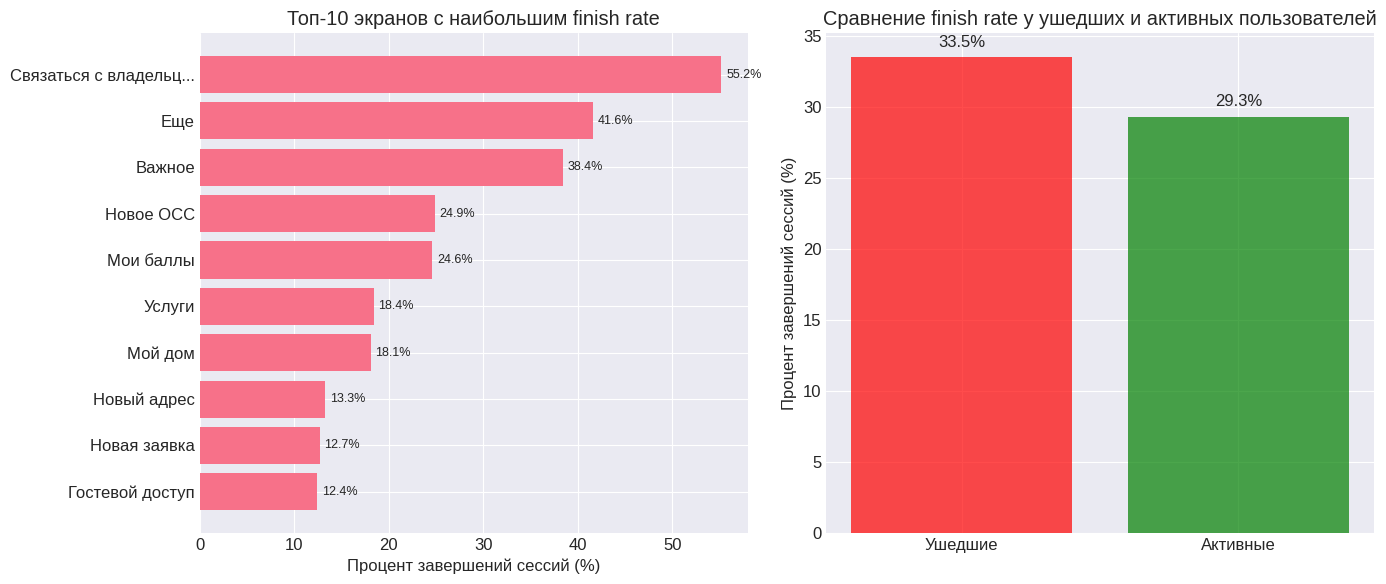

In [56]:
# Визуализация finish rate
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
# Топ-10 экранов по finish rate (с минимум 100 посещений)
top_screens_viz = screen_finish_stats[screen_finish_stats['total_visits'] > 100].head(10)
bars1 = plt.barh(range(len(top_screens_viz)), top_screens_viz['finish_rate'] * 100)
plt.yticks(range(len(top_screens_viz)), [f"{s[:20]}..." if len(s) > 20 else s for s in top_screens_viz.index])
plt.xlabel('Процент завершений сессий (%)')
plt.title('Топ-10 экранов с наибольшим finish rate')
plt.gca().invert_yaxis()

# Добавляем значения
for i, (idx, row) in enumerate(top_screens_viz.iterrows()):
    plt.text(row['finish_rate'] * 100 + 0.5, i, f"{row['finish_rate']*100:.1f}%", va='center', fontsize=9)

plt.subplot(1, 2, 2)
# Сравнение finish rate у ушедших и активных
categories = ['Ушедшие', 'Активные']
values = [finish_rate_left * 100, finish_rate_active * 100]
colors = ['red', 'green']

bars2 = plt.bar(categories, values, color=colors, alpha=0.7)
plt.ylabel('Процент завершений сессий (%)')
plt.title('Сравнение finish rate у ушедших и активных пользователей')

# Добавляем значения
for bar, value in zip(bars2, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{value:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [57]:
# 4. АНАЛИЗ ПЕРЕХОДОВ МЕЖДУ ЭКРАНАМИ:
print("\n4. АНАЛИЗ ПЕРЕХОДОВ МЕЖДУ ЭКРАНАМИ:")

# Создаем матрицу переходов для ушедших пользователей
df_sorted = df.sort_values(['device_id', 'session_id', 'event_dt'])

# Добавляем следующий экран
df_sorted['next_screen'] = df_sorted.groupby(['device_id', 'session_id'])['screen'].shift(-1)
df_sorted['next_feature'] = df_sorted.groupby(['device_id', 'session_id'])['feature'].shift(-1)

# Фильтруем только ушедших
transitions_left = df_sorted[df_sorted['is_churn'] == 1].dropna(subset=['next_screen'])

# Топ переходов
print("\nТоп-10 переходов между экранами у ушедших пользователей:")
top_transitions = transitions_left.groupby(['screen', 'next_screen']).size().reset_index(name='count')
top_transitions = top_transitions.sort_values('count', ascending=False).head(10)

for _, row in top_transitions.iterrows():
    print(f"  • {row['screen']} → {row['next_screen']}: {row['count']:,}")

# Анализ переходов по функциям
print("\nТоп-10 переходов между функциями у ушедших пользователей:")
feature_transitions = transitions_left.groupby(['feature', 'next_feature']).size().reset_index(name='count')
feature_transitions = feature_transitions.sort_values('count', ascending=False).head(10)

for _, row in feature_transitions.iterrows():
    print(f"  • {row['feature']} → {row['next_feature']}: {row['count']:,}")


4. АНАЛИЗ ПЕРЕХОДОВ МЕЖДУ ЭКРАНАМИ:

Топ-10 переходов между экранами у ушедших пользователей:
  • Еще → Еще: 93,060
  • Новая заявка → Новая заявка: 72,424
  • Важное → Важное: 17,150
  • Еще → Новая заявка: 16,380
  • Еще → Важное: 14,106
  • Важное → Еще: 9,310
  • Новая заявка → Еще: 8,135
  • Услуги → Услуги: 5,472
  • Еще → Мои баллы: 3,553
  • Мои баллы → Мои баллы: 2,571

Топ-10 переходов между функциями у ушедших пользователей:
  • Открытие экрана → Открытие экрана: 25,690
  • Открытие экрана → Переход в раздел 'Опросы и собрания собственников': 23,609
  • Просмотр уведомления → Просмотр уведомления: 17,150
  • Открытие экрана → Просмотр уведомления: 13,383
  • Открытие экрана → Переход в раздел 'Заявки': 12,196
  • Переход в раздел 'Опросы и собрания собственников' → Открытие экрана: 9,878
  • Выбор через теги → Выбор через теги: 7,636
  • Переход в раздел 'Заявки' → Открытие экрана: 7,362
  • Просмотр уведомления → Открытие экрана: 6,234
  • Возврат на предыдущий этап → Возв

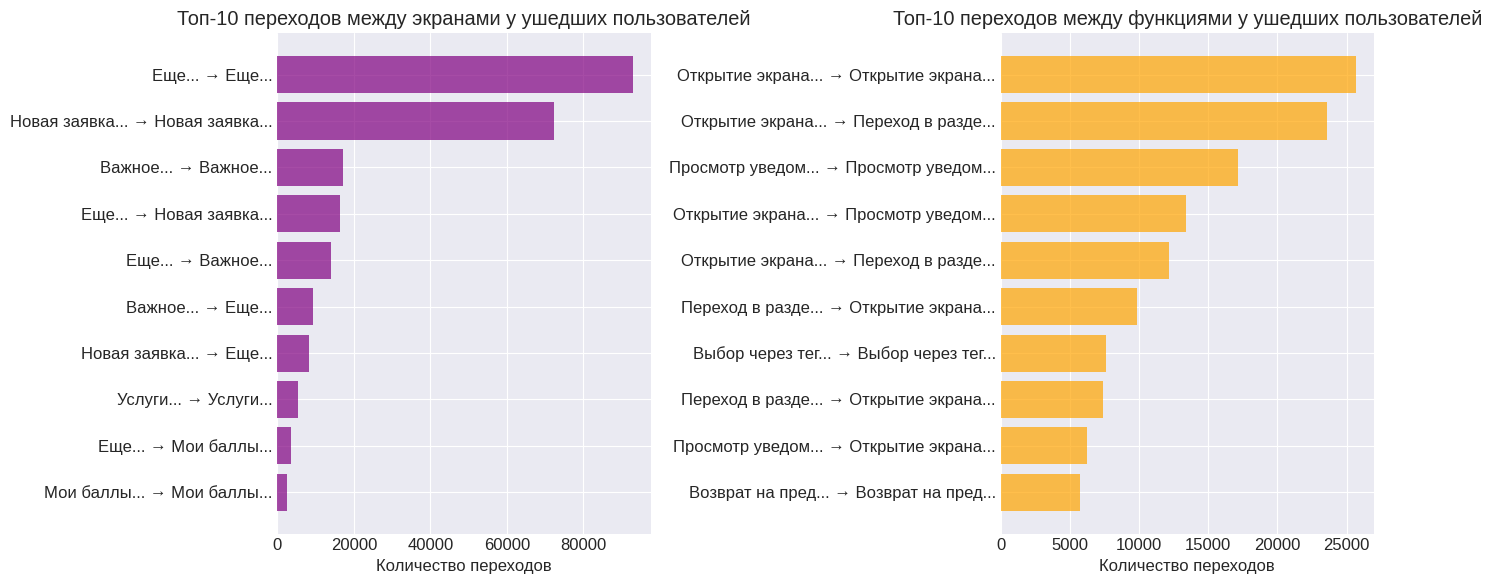

In [58]:
# Визуализация топ переходов
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
# Топ переходов экранов
plt.barh(range(len(top_transitions)), top_transitions['count'].values,
         color='purple', alpha=0.7)
plt.yticks(range(len(top_transitions)),
           [f"{row['screen'][:15]}... → {row['next_screen'][:15]}..."
            for _, row in top_transitions.iterrows()])
plt.xlabel('Количество переходов')
plt.title('Топ-10 переходов между экранами у ушедших пользователей')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
# Топ переходов функций
plt.barh(range(len(feature_transitions)), feature_transitions['count'].values,
         color='orange', alpha=0.7)
plt.yticks(range(len(feature_transitions)),
           [f"{row['feature'][:15]}... → {row['next_feature'][:15]}..."
            for _, row in feature_transitions.iterrows()])
plt.xlabel('Количество переходов')
plt.title('Топ-10 переходов между функциями у ушедших пользователей')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [59]:
print("\nСТАТИСТИЧЕСКИЕ ТЕСТЫ И КЛЮЧЕВЫЕ ВЫВОДЫ")

# Проверка значимости различий в возрасте
if 'age' in df.columns:
    age_left = df_left['age'].dropna()
    age_active = df_active['age'].dropna()

    if len(age_left) > 0 and len(age_active) > 0:
        t_stat_age, p_val_age = stats.ttest_ind(age_left, age_active, equal_var=False, nan_policy='omit')
        print(f"\n1. Различия в возрасте между ушедшими и активными:")
        print(f"   T-статистика: {t_stat_age:.3f}")
        print(f"   P-значение: {p_val_age:.4f}")
        if p_val_age < 0.05:
            print(f"   Различия СТАТИСТИЧЕСКИ ЗНАЧИМЫ (p < 0.05)")
        else:
            print(f"   Различия не статистически значимы (p ≥ 0.05)")
    else:
        print("\n1. Недостаточно данных для проверки различий в возрасте")
else:
    print("\n1. Колонка 'age' отсутствует в данных")


СТАТИСТИЧЕСКИЕ ТЕСТЫ И КЛЮЧЕВЫЕ ВЫВОДЫ

1. Различия в возрасте между ушедшими и активными:
   T-статистика: -65.129
   P-значение: 0.0000
   Различия СТАТИСТИЧЕСКИ ЗНАЧИМЫ (p < 0.05)


In [60]:
# Проверка значимости различий по количеству сессий
if len(sessions_per_user_left) > 0 and len(sessions_per_user_active) > 0:
    t_stat_sessions, p_val_sessions = stats.mannwhitneyu(
        sessions_per_user_left,
        sessions_per_user_active,
        alternative='two-sided'
    )
    print(f"\n2. Различия в количестве сессий:")
    print(f"   U-статистика Манна-Уитни: {t_stat_sessions:.3f}")
    print(f"   P-значение: {p_val_sessions:.4f}")
    if p_val_sessions < 0.05:
        print(f"   Различия СТАТИСТИЧЕСКИ ЗНАЧИМЫ (p < 0.05)")
    else:
        print(f"   Различия не статистически значимы (p ≥ 0.05)")
else:
    print("\n2. Недостаточно данных для проверки различий в сессиях")

# Проверка связи ОС с оттоком
if 'os' in df.columns:
    os_contingency = pd.crosstab(df['os'], df['is_churn'])
    if os_contingency.shape[0] > 1 and os_contingency.shape[1] > 1:
        chi2_os, p_val_os, dof_os, expected_os = stats.chi2_contingency(os_contingency)
        print(f"\n3. Связь операционной системы с оттоком:")
        print(f"   Хи-квадрат: {chi2_os:.3f}")
        print(f"   P-значение: {p_val_os:.4f}")
        if p_val_os < 0.05:
            print(f"   Связь СТАТИСТИЧЕСКИ ЗНАЧИМА (p < 0.05)")
        else:
            print(f"   Связь не статистически значима (p ≥ 0.05)")
    else:
        print("\n3. Недостаточно данных для проверки связи ОС с оттоком")
else:
    print("\n3. Колонка 'os' отсутствует в данных")


2. Различия в количестве сессий:
   U-статистика Манна-Уитни: 1755598774.500
   P-значение: 0.0000
   Различия СТАТИСТИЧЕСКИ ЗНАЧИМЫ (p < 0.05)

3. Связь операционной системы с оттоком:
   Хи-квадрат: 6559.437
   P-значение: 0.0000
   Связь СТАТИСТИЧЕСКИ ЗНАЧИМА (p < 0.05)


In [62]:
# Собираем ключевые метрики
summary_metrics = {}

# Проверяем существование переменных перед добавлением
if 'is_churn' in df.columns:
    summary_metrics['Общий процент оттока'] = f"{df['is_churn'].mean()*100:.1f}%"

if 'churned_lifetime' in locals():
    summary_metrics['Среднее время жизни (ушедшие)'] = f"{churned_lifetime.mean():.1f} дней"

if 'active_lifetime' in locals():
    summary_metrics['Среднее время жизни (активные)'] = f"{active_lifetime.mean():.1f} дней"

if 'sessions_per_user_left' in locals() and 'sessions_per_user_active' in locals():
    summary_metrics['Разница в сессиях'] = f"{sessions_per_user_active.mean() - sessions_per_user_left.mean():.1f}"

if 'actions_per_user_left' in locals() and 'actions_per_user_active' in locals():
    summary_metrics['Разница в действиях'] = f"{actions_per_user_active.mean() - actions_per_user_left.mean():.1f}"

if 'is_finish' in df.columns:
    summary_metrics['Процент завершений сессий'] = f"{df['is_finish'].mean()*100:.1f}%"

if 'action' in df.columns:
    summary_metrics['Пропуски в action'] = f"{df['action'].isna().mean()*100:.1f}%"

print("\nКЛЮЧЕВЫЕ МЕТРИКИ:")
for metric, value in summary_metrics.items():
    print(f"  • {metric}: {value}")


КЛЮЧЕВЫЕ МЕТРИКИ:
  • Общий процент оттока: 11.7%
  • Среднее время жизни (ушедшие): 3.5 дней
  • Среднее время жизни (активные): 22.5 дней
  • Разница в сессиях: 5.0
  • Разница в действиях: 17.9
  • Процент завершений сессий: 29.8%
  • Пропуски в action: 52.5%


In [63]:
print("\nКРИТИЧЕСКИЕ ТОЧКИ:")
critical_points = [
    "1. Короткое время жизни ушедших пользователей",
    "2. Значительно меньше сессий и действий у ушедших",
    "3. Конкретные модели устройств с высоким оттоком"
]

# Добавляем динамические точки, если есть данные
if 'top_last_screens' in locals() and len(top_last_screens) > 0:
    critical_points.append(f"4. {top_last_screens.index[0]} - самый частый последний экран перед уходом")

if 'top_finish_screens' in locals() and len(top_finish_screens) > 0:
    critical_points.append(f"5. {top_finish_screens.index[0]} - самый высокий finish rate")

if 'hourly_activity' in locals() and 'daily_activity' in locals():
    critical_points.append(f"6. Пик активности в {hourly_activity.idxmax()} часов, пиковый день - {daily_activity.idxmax()}")

for point in critical_points:
    print(f"  • {point}")

print("\nРЕКОМЕНДАЦИИ:")
recommendations = [
    "1. Фокусироваться на удержании пользователей в первые 7 дней",
    "2. Улучшить onboarding для новых пользователей",
    "3. Проанализировать причины высокого оттока на проблемных экранах",
    "4. Оптимизировать пользовательский опыт на устройствах с высоким оттоком",
    "5. Создать персонализированные кампании для разных сегментов пользователей"
]

for rec in recommendations:
    print(f"  • {rec}")


КРИТИЧЕСКИЕ ТОЧКИ:
  • 1. Короткое время жизни ушедших пользователей
  • 2. Значительно меньше сессий и действий у ушедших
  • 3. Конкретные модели устройств с высоким оттоком
  • 4. Еще - самый частый последний экран перед уходом
  • 5. Связаться с владельцем ТС - самый высокий finish rate
  • 6. Пик активности в 10 часов, пиковый день - Tuesday

РЕКОМЕНДАЦИИ:
  • 1. Фокусироваться на удержании пользователей в первые 7 дней
  • 2. Улучшить onboarding для новых пользователей
  • 3. Проанализировать причины высокого оттока на проблемных экранах
  • 4. Оптимизировать пользовательский опыт на устройствах с высоким оттоком
  • 5. Создать персонализированные кампании для разных сегментов пользователей


Анализ первых 24 часа после регистрации

In [64]:
print("\nАНАЛИЗ ПЕРВЫХ 24 ЧАСОВ ЖИЗНИ ПОЛЬЗОВАТЕЛЕЙ")

# Находим время регистрации (первое событие)
first_events = df.groupby('device_id')['event_dt'].min().reset_index()
first_events.columns = ['device_id', 'registration_time']

# Присоединяем к основным данным
df_with_reg = df.merge(first_events, on='device_id')
df_with_reg['hours_since_reg'] = (df_with_reg['event_dt'] - df_with_reg['registration_time']).dt.total_seconds() / 3600

# Анализ активности в первые 24 часа
first_24h = df_with_reg[df_with_reg['hours_since_reg'] <= 24]

print(f"\nАКТИВНОСТЬ В ПЕРВЫЕ 24 ЧАСА:")
print(f"  • Пользователей, активных в первые 24ч: {first_24h['device_id'].nunique():,}")
print(f"  • Всего действий в первые 24ч: {len(first_24h):,}")
print(f"  • Среднее действий на пользователя: {len(first_24h)/first_24h['device_id'].nunique():.1f}")

# Сравнение ушедших и активных
churned_first_24h = first_24h[first_24h['is_churn'] == 1]
active_first_24h = first_24h[first_24h['is_churn'] == 0]

print(f"\nСРАВНЕНИЕ УШЕДШИХ И АКТИВНЫХ:")
print(f"  • Ушедшие - среднее действий в первые 24ч: {len(churned_first_24h)/churned_first_24h['device_id'].nunique():.1f}")
print(f"  • Активные - среднее действий в первые 24ч: {len(active_first_24h)/active_first_24h['device_id'].nunique():.1f}")

# Анализ "моментального ухода" (пользователи с 1 сессией и 1-2 действиями)
instant_churn = df.groupby('device_id').filter(
    lambda x: (x['is_churn'].iloc[0] == 1) and
    (x['session_id'].nunique() == 1) and
    (len(x) <= 3)
)

print(f"\nМОМЕНТАЛЬНЫЙ ОТТОК (1 сессия, ≤3 действий):")
print(f"  • Пользователей: {instant_churn['device_id'].nunique():,}")
print(f"  • Доля от всех ушедших: {instant_churn['device_id'].nunique()/len(df_left['device_id'].unique())*100:.1f}%")

# Анализ первых действий у "моментально ушедших"
if len(instant_churn) > 0:
    print(f"\nПЕРВЫЕ ДЕЙСТВИЯ У МОМЕНТАЛЬНО УШЕДШИХ:")

    # Сортируем по времени
    instant_churn_sorted = instant_churn.sort_values(['device_id', 'event_dt'])

    # Первые экраны
    first_screens = instant_churn_sorted.groupby('device_id').first()['screen'].value_counts().head(5)
    print(f"  • Топ-5 первых экранов:")
    for screen, count in first_screens.items():
        print(f"    - {screen}: {count} ({count/len(first_screens)*100:.1f}%)")

    # Первые функции
    first_features = instant_churn_sorted.groupby('device_id').first()['feature'].value_counts().head(5)
    print(f"  • Топ-5 первых функций:")
    for feature, count in first_features.items():
        print(f"    - {feature}: {count} ({count/len(first_features)*100:.1f}%)")


АНАЛИЗ ПЕРВЫХ 24 ЧАСОВ ЖИЗНИ ПОЛЬЗОВАТЕЛЕЙ

АКТИВНОСТЬ В ПЕРВЫЕ 24 ЧАСА:
  • Пользователей, активных в первые 24ч: 179,976
  • Всего действий в первые 24ч: 924,886
  • Среднее действий на пользователя: 5.1

СРАВНЕНИЕ УШЕДШИХ И АКТИВНЫХ:
  • Ушедшие - среднее действий в первые 24ч: 4.3
  • Активные - среднее действий в первые 24ч: 5.6

МОМЕНТАЛЬНЫЙ ОТТОК (1 сессия, ≤3 действий):
  • Пользователей: 23,141
  • Доля от всех ушедших: 39.1%

ПЕРВЫЕ ДЕЙСТВИЯ У МОМЕНТАЛЬНО УШЕДШИХ:
  • Топ-5 первых экранов:
    - Еще: 18883 (377660.0%)
    - Важное: 3491 (69820.0%)
    - Новая заявка: 335 (6700.0%)
    - Услуги: 195 (3900.0%)
    - Связаться с владельцем ТС: 107 (2140.0%)
  • Топ-5 первых функций:
    - Открытие экрана: 19276 (385520.0%)
    - Просмотр уведомления: 3491 (69820.0%)
    - Выбор через теги: 82 (1640.0%)
    - Выбор квартиры: 72 (1440.0%)
    - Возврат на предыдущий этап: 41 (820.0%)


Анализ технических проблем и ошибок

In [71]:
# Ищем возможные ошибки в action (например, error, fail, crash)
error_keywords = ['error', 'fail', 'crash', 'exception', 'timeout', 'ошибка', 'сбой']

print(f"\nПОИСК ОШИБОК В ДЕЙСТВИЯХ:")
error_actions = []

# Преобразуем action в строку с обработкой NaN
df['action_str'] = df['action'].astype(str).fillna('')

for keyword in error_keywords:
    error_matches = df[df['action_str'].str.lower().str.contains(keyword, na=False)]
    if len(error_matches) > 0:
        error_actions.append((keyword, len(error_matches)))
        print(f"  • Найдено действий с '{keyword}': {len(error_matches):,}")

if error_actions:
    # Анализ оттока после ошибок
    print(f"\nОТТОК ПОСЛЕ ОШИБОК:")
    for keyword, count in error_actions:
        error_users = df[df['action_str'].str.lower().str.contains(keyword, na=False)]['device_id'].unique()
        churn_after_error = df[df['device_id'].isin(error_users)]['is_churn'].mean() * 100
        print(f"  • После действий с '{keyword}': {churn_after_error:.1f}% оттока")
else:
    print(f"  • Ошибки не найдены в данных")

# Анализ пустых/непонятных действий
print(f"\nАНАЛИЗ ПУСТЫХ/НЕПОНЯТНЫХ ДЕЙСТВИЙ:")
if 'action' in df.columns:
    # Заменяем NaN на строку 'NaN' для анализа
    df['action_filled'] = df['action'].fillna('MISSING_ACTION')

    # Самые странные/непонятные действия
    all_actions = df['action_filled'].value_counts()
    strange_actions = all_actions[all_actions < 10]  # Очень редкие действия

    print(f"  • Очень редких действий (≤10 раз): {len(strange_actions):,}")
    print(f"  • Пользователей с редкими действиями: {df[df['action_filled'].isin(strange_actions.index)]['device_id'].nunique():,}")

    # Отток после редких действий
    if len(strange_actions) > 0:
        strange_users = df[df['action_filled'].isin(strange_actions.index)]['device_id'].unique()
        churn_strange = df[df['device_id'].isin(strange_users)]['is_churn'].mean() * 100
        print(f"  • Отток после редких действий: {churn_strange:.1f}%")

        # Показать примеры редких действий
        print(f"\n  • Примеры редких действий:")
        for action in strange_actions.index[:5]:
            print(f"    - '{action}': {strange_actions[action]} раз")

# Удаляем временные колонки
if 'action_str' in df.columns:
    df.drop('action_str', axis=1, inplace=True)
if 'action_filled' in df.columns:
    df.drop('action_filled', axis=1, inplace=True)


ПОИСК ОШИБОК В ДЕЙСТВИЯХ:
  • Ошибки не найдены в данных

АНАЛИЗ ПУСТЫХ/НЕПОНЯТНЫХ ДЕЙСТВИЙ:
  • Очень редких действий (≤10 раз): 63
  • Пользователей с редкими действиями: 171
  • Отток после редких действий: 3.9%

  • Примеры редких действий:
    - 'Слабая течь полотенцесушителя': 9 раз
    - 'Некачественное содержание дорожных знаков во дворе': 9 раз
    - 'Файл успешно загружен': 9 раз
    - 'Незаконное проживание мигрантов в местах общего пользования  многоквартирного дома': 9 раз
    - 'Течь по стене в квартиру, подъезд из внутреннего водостока (разгерметизация, засор)': 9 раз


In [72]:
print("\nАНАЛИЗ ДЛИННЫХ И СЛОЖНЫХ ПРОЦЕССОВ")
# Анализ длины сессий
session_lengths = df.groupby(['device_id', 'session_id']).agg({
    'event_dt': ['min', 'max']
})
session_lengths.columns = ['start', 'end']
session_lengths['duration_seconds'] = (session_lengths['end'] - session_lengths['start']).dt.total_seconds()
session_lengths = session_lengths.reset_index()

# Присоединяем информацию о churn
session_with_churn = session_lengths.merge(
    df[['device_id', 'is_churn']].drop_duplicates(),
    on='device_id'
)

print(f"\nДЛИТЕЛЬНОСТЬ СЕССИЙ:")
print(f"  • Средняя длительность сессии: {session_with_churn['duration_seconds'].mean()/60:.1f} минут")
print(f"  • Медианная длительность: {session_with_churn['duration_seconds'].median()/60:.1f} минут")

# Сравнение ушедших и активных
churned_sessions = session_with_churn[session_with_churn['is_churn'] == 1]
active_sessions = session_with_churn[session_with_churn['is_churn'] == 0]

print(f"\nСРАВНЕНИЕ:")
print(f"  • Ушедшие: {churned_sessions['duration_seconds'].mean()/60:.1f} мин (медиана: {churned_sessions['duration_seconds'].median()/60:.1f} мин)")
print(f"  • Активные: {active_sessions['duration_seconds'].mean()/60:.1f} мин (медиана: {active_sessions['duration_seconds'].median()/60:.1f} мин)")

# Анализ очень длинных сессий (возможные проблемы) - ИСПРАВЛЕНА ОШИБКА
long_sessions = session_with_churn[session_with_churn['duration_seconds'] > 3600]  # > 1 час
print(f"\nОЧЕНЬ ДЛИННЫЕ СЕССИИ (>1 часа):")
print(f"  • Количество: {len(long_sessions):,}")
print(f"  • Пользователей: {long_sessions['device_id'].nunique():,}")
if len(long_sessions) > 0:
    print(f"  • Отток среди них: {long_sessions['is_churn'].mean()*100:.1f}%")

    # Анализ очень коротких сессий (< 30 секунд)
    short_sessions = session_with_churn[session_with_churn['duration_seconds'] < 30]  # < 30 секунд
    print(f"\nОЧЕНЬ КОРОТКИЕ СЕССИИ (<30 секунд):")
    print(f"  • Количество: {len(short_sessions):,}")
    print(f"  • Пользователей: {short_sessions['device_id'].nunique():,}")
    if len(short_sessions) > 0:
        print(f"  • Отток среди них: {short_sessions['is_churn'].mean()*100:.1f}%")


АНАЛИЗ ДЛИННЫХ И СЛОЖНЫХ ПРОЦЕССОВ

ДЛИТЕЛЬНОСТЬ СЕССИЙ:
  • Средняя длительность сессии: 13.6 минут
  • Медианная длительность: 0.1 минут

СРАВНЕНИЕ:
  • Ушедшие: 6.2 мин (медиана: 0.1 мин)
  • Активные: 14.8 мин (медиана: 0.1 мин)

ОЧЕНЬ ДЛИННЫЕ СЕССИИ (>1 часа):
  • Количество: 743
  • Пользователей: 234
  • Отток среди них: 17.2%

ОЧЕНЬ КОРОТКИЕ СЕССИИ (<30 секунд):
  • Количество: 728,308
  • Пользователей: 153,161
  • Отток среди них: 12.6%


In [73]:
print("\nАНАЛИЗ ПОСЛЕДОВАТЕЛЬНОСТЕЙ ДЕЙСТВИЙ ДО УХОДА")


# Получаем последние 5 действий перед уходом для каждого пользователя
df_sorted = df.sort_values(['device_id', 'event_dt'])

# Для ушедших пользователей
churned_users_ids = df_left['device_id'].unique()
churned_sequences = {}

for user_id in churned_users_ids[:100]:  # Берем первых 100 для анализа
    user_actions = df_sorted[df_sorted['device_id'] == user_id]
    if len(user_actions) >= 5:
        last_5 = user_actions.tail(5)
        sequence = tuple(zip(last_5['screen'], last_5['feature'], last_5['action']))
        churned_sequences[user_id] = sequence

# Находим наиболее частые последовательности
if churned_sequences:
    # Преобразуем в строки для анализа
    sequence_strings = []
    for seq in churned_sequences.values():
        seq_str = ' → '.join([f"{s}/{f}/{a}" for s, f, a in seq])
        sequence_strings.append(seq_str)

    # Находим самые частые последовательности
    from collections import Counter
    seq_counter = Counter(sequence_strings)

    print(f"\nТОП-5 САМЫХ ЧАСТЫХ ПОСЛЕДОВАТЕЛЬНОСТЕЙ ПЕРЕД УХОДОМ:")
    for seq, count in seq_counter.most_common(5):
        print(f"\n  • Встречается у {count} пользователей:")
        steps = seq.split(' → ')
        for i, step in enumerate(steps, 1):
            print(f"    Шаг {i}: {step}")


АНАЛИЗ ПОСЛЕДОВАТЕЛЬНОСТЕЙ ДЕЙСТВИЙ ДО УХОДА

ТОП-5 САМЫХ ЧАСТЫХ ПОСЛЕДОВАТЕЛЬНОСТЕЙ ПЕРЕД УХОДОМ:

  • Встречается у 3 пользователей:
    Шаг 1: Важное/Просмотр уведомления/Тап на уведомление
    Шаг 2: Важное/Просмотр уведомления/Тап на уведомление
    Шаг 3: Важное/Просмотр уведомления/Тап на уведомление
    Шаг 4: Важное/Просмотр уведомления/Тап на уведомление
    Шаг 5: Важное/Просмотр уведомления/Тап на уведомление

  • Встречается у 2 пользователей:
    Шаг 1: Еще/Открытие экрана/nan
    Шаг 2: Еще/Открытие экрана/nan
    Шаг 3: Еще/Открытие экрана/nan
    Шаг 4: Еще/Открытие экрана/nan
    Шаг 5: Еще/Открытие экрана/nan

  • Встречается у 2 пользователей:
    Шаг 1: Новая заявка/Открытие экрана/nan
    Шаг 2: Еще/Открытие экрана/nan
    Шаг 3: Еще/Переход в раздел 'Заявки'/Тап на кнопку 'Заявки'
    Шаг 4: Новая заявка/Открытие экрана/nan
    Шаг 5: Новая заявка/Открытие экрана/nan

  • Встречается у 2 пользователей:
    Шаг 1: Еще/Переход в раздел 'Опросы и собрания собственн

In [74]:
print("\nАНАЛИЗ РАЗРЫВА В ИСПОЛЬЗОВАНИИ (USAGE GAP)")

# Рассчитываем время между сессиями для каждого пользователя
df_sorted = df.sort_values(['device_id', 'event_dt'])
df_sorted['prev_event'] = df_sorted.groupby('device_id')['event_dt'].shift(1)
df_sorted['days_between_events'] = (df_sorted['event_dt'] - df_sorted['prev_event']).dt.days

# Анализ разрывов
print(f"\nРАЗРЫВЫ МЕЖДУ ДЕЙСТВИЯМИ:")
print(f"  • Среднее дней между действиями: {df_sorted['days_between_events'].mean():.1f}")
print(f"  • Медиана дней между действиями: {df_sorted['days_between_events'].median():.1f}")

# Анализ "критического разрыва"
critical_gap = 7  # дней
long_gaps = df_sorted[df_sorted['days_between_events'] > critical_gap]

print(f"\nКРИТИЧЕСКИЕ РАЗРЫВЫ (>7 дней):")
print(f"  • Количество разрывов: {len(long_gaps):,}")
print(f"  • Уникальных пользователей: {long_gaps['device_id'].nunique():,}")

# Отток после критических разрывов
if len(long_gaps) > 0:
    users_with_long_gaps = long_gaps['device_id'].unique()
    churn_after_gap = df[df['device_id'].isin(users_with_long_gaps)]['is_churn'].mean() * 100
    print(f"  • Отток после разрыва >7 дней: {churn_after_gap:.1f}%")

    # Анализ, что делали до разрыва
    print(f"\nЧТО ДЕЛАЛИ ДО КРИТИЧЕСКОГО РАЗРЫВА:")
    actions_before_gap = long_gaps.groupby('device_id').first()
    top_screens_before = actions_before_gap['screen'].value_counts().head(5)

    print(f"  • Топ-5 экранов перед разрывом:")
    for screen, count in top_screens_before.items():
        print(f"    - {screen}: {count} ({count/len(actions_before_gap)*100:.1f}%)")


АНАЛИЗ РАЗРЫВА В ИСПОЛЬЗОВАНИИ (USAGE GAP)

РАЗРЫВЫ МЕЖДУ ДЕЙСТВИЯМИ:
  • Среднее дней между действиями: 0.8
  • Медиана дней между действиями: 0.0

КРИТИЧЕСКИЕ РАЗРЫВЫ (>7 дней):
  • Количество разрывов: 115,020
  • Уникальных пользователей: 81,641
  • Отток после разрыва >7 дней: 4.7%

ЧТО ДЕЛАЛИ ДО КРИТИЧЕСКОГО РАЗРЫВА:
  • Топ-5 экранов перед разрывом:
    - Еще: 64223 (78.7%)
    - Важное: 10912 (13.4%)
    - Новая заявка: 3316 (4.1%)
    - Мой дом: 1625 (2.0%)
    - Услуги: 504 (0.6%)



АНАЛИЗ УДОВЛЕТВОРЕННОСТИ ЧЕРЕЗ ПАТТЕРНЫ ДЕЙСТВИЙ

Всего уникальных действий: 316
Действий с пропусками: 1,765,376 (52.5%)

ТОП-20 САМЫХ ЧАСТЫХ ДЕЙСТВИЙ:
  • Тап на уведомление                                :  234,474 (6.98%)
  • Тап на кнопку 'Заявки'                            :  200,179 (5.96%)
  • Тап на стрелку назад                              :  141,793 (4.22%)
  • Тап на кнопку 'Опросы и собрания собственников'   :  126,429 (3.76%)
  • Тап на заявку                                     :   87,227 (2.60%)
  • Тап на кнопку 'Мои платежи'                       :   58,452 (1.74%)
  • выбор тега 1                                      :   57,488 (1.71%)
  • Тап на кнопку 'Создать заявку'                    :   56,410 (1.68%)
  • Тап на кнопку поиска                              :   54,895 (1.63%)
  • Тап на кнопку 'Соседей'                           :   43,188 (1.29%)
  • Тап на кнопку 'Приборы учёта'                     :   42,017 (1.25%)
  • Тап на квартиру                        

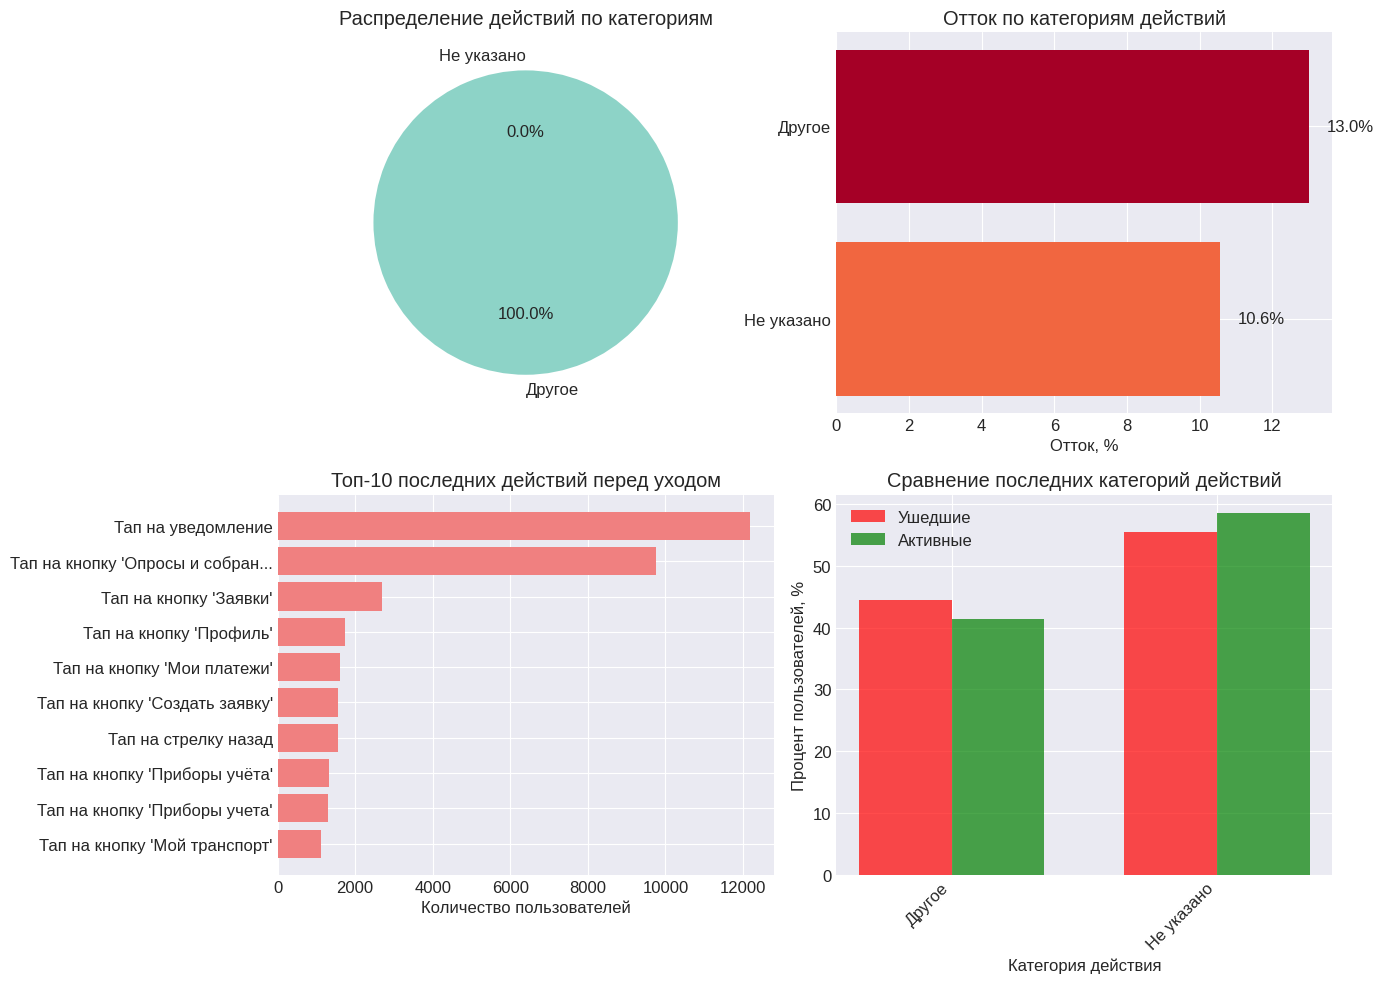

In [83]:
print("\nАНАЛИЗ УДОВЛЕТВОРЕННОСТИ ЧЕРЕЗ ПАТТЕРНЫ ДЕЙСТВИЙ")
# Посмотрим топ-20 самых частых действий
if 'action' in df.columns:
    action_counts = df['action'].value_counts()
    print(f"\nВсего уникальных действий: {len(action_counts):,}")
    print(f"Действий с пропусками: {df['action'].isna().sum():,} ({df['action'].isna().mean()*100:.1f}%)")

    print("\nТОП-20 САМЫХ ЧАСТЫХ ДЕЙСТВИЙ:")
    for action, count in action_counts.head(20).items():
        percentage = count / len(df) * 100
        print(f"  • {str(action)[:50]:50s}: {count:8,} ({percentage:.2f}%)")
else:
    print("Колонка 'action' отсутствует в данных")

# 2. Попробуем категоризировать действия для анализа удовлетворенности
print("\n\n2. КАТЕГОРИЗАЦИЯ ДЕЙСТВИЙ ДЛЯ АНАЛИЗА УДОВЛЕТВОРЕННОСТИ")

def categorize_action_for_satisfaction(action):
    """Категоризация действий для анализа удовлетворенности"""
    if pd.isna(action):
        return 'Не указано'

    action_str = str(action).lower()

    # Оцениваем по содержимому
    # Позитивные паттерны
    if any(word in action_str for word in ['save', 'bookmark', 'favorite', 'like', 'love', 'rate_5', 'rate_4']):
        return 'Позитивное'
    # Негативные паттерны
    elif any(word in action_str for word in ['delete', 'remove', 'cancel', 'unsubscribe', 'rate_1', 'rate_2', 'report']):
        return 'Негативное'
    # Нейтральные паттерны
    elif any(word in action_str for word in ['view', 'open', 'close', 'click', 'scroll', 'search']):
        return 'Нейтральное/Навигация'
    # Возможные транзакции
    elif any(word in action_str for word in ['buy', 'purchase', 'order', 'pay', 'checkout']):
        return 'Транзакционное'
    # Социальные взаимодействия
    elif any(word in action_str for word in ['share', 'comment', 'message', 'chat']):
        return 'Социальное'
    else:
        return 'Другое'

# Применяем категоризацию
df['action_category_satisfaction'] = df['action'].apply(categorize_action_for_satisfaction)

# Анализ распределения
print("\nРАСПРЕДЕЛЕНИЕ ДЕЙСТВИЙ ПО КАТЕГОРИЯМ:")
category_stats = df.groupby('action_category_satisfaction').agg({
    'action': 'count',
    'is_churn': 'mean'
}).rename(columns={'action': 'count', 'is_churn': 'churn_rate'}).sort_values('count', ascending=False)

for category, row in category_stats.iterrows():
    percentage = row['count'] / len(df) * 100
    print(f"  • {category:20s}: {row['count']:8,} ({percentage:.1f}%), отток: {row['churn_rate']*100:.1f}%")

# 3. Анализ оттока после разных типов действий
print("\n\n3. АНАЛИЗ ОТТОКА ПОСЛЕ РАЗНЫХ ТИПОВ ДЕЙСТВИЙ")

# Для каждого пользователя смотрим, какие категории действий он совершал
user_action_categories = df.groupby('device_id')['action_category_satisfaction'].apply(set).reset_index()
user_action_categories['is_churn'] = user_action_categories['device_id'].isin(churned_users).astype(int)

# Анализ комбинаций категорий
print("\nКОМБИНАЦИИ КАТЕГОРИЙ И ОТТОК:")
combinations_analysis = []

for _, row in user_action_categories.iterrows():
    categories = tuple(sorted(list(row['action_category_satisfaction'])))
    combinations_analysis.append({
        'categories': categories,
        'is_churn': row['is_churn']
    })

combinations_df = pd.DataFrame(combinations_analysis)
combinations_stats = combinations_df.groupby('categories').agg({
    'is_churn': ['count', 'mean']
}).round(3)

combinations_stats.columns = ['users', 'churn_rate']
combinations_stats = combinations_stats.sort_values('users', ascending=False)

print("\nТоп-10 самых частых комбинаций категорий действий:")
for categories, row in combinations_stats.head(10).iterrows():
    categories_str = ', '.join(categories)
    print(f"  • {categories_str[:60]:60s}: {row['users']:4,} пользователей, отток: {row['churn_rate']*100:.1f}%")

# 4. Анализ "последнего впечатления" - что делали перед уходом
print("\n\n4. ПОСЛЕДНЕЕ ВПЕЧАТЛЕНИЕ ПЕРЕД УХОДОМ")

# Получаем последнее действие каждого ушедшего пользователя
df_sorted = df.sort_values(['device_id', 'event_dt'])

last_actions_churned = df_sorted[df_sorted['is_churn'] == 1].groupby('device_id').last()

print(f"\nКАТЕГОРИИ ПОСЛЕДНИХ ДЕЙСТВИЙ У УШЕДШИХ:")
if len(last_actions_churned) > 0:
    last_action_cats = last_actions_churned['action_category_satisfaction'].value_counts()
    for category, count in last_action_cats.items():
        percentage = count / len(last_actions_churned) * 100
        print(f"  • {category:20s}: {count:6,} ({percentage:.1f}%)")

    # Самые частые последние действия
    print(f"\nТОП-5 САМЫХ ЧАСТЫХ ПОСЛЕДНИХ ДЕЙСТВИЙ:")
    top_last_actions = last_actions_churned['action'].value_counts().head(5)
    for action, count in top_last_actions.items():
        percentage = count / len(last_actions_churned) * 100
        print(f"  • {str(action)[:40]:40s}: {count:6,} ({percentage:.1f}%)")

# 5. Визуализация
print("\n\n5. ВИЗУАЛИЗАЦИЯ")
plt.figure(figsize=(14, 10))

# График 1: Распределение категорий действий
plt.subplot(2, 2, 1)
category_counts = category_stats['count']
colors = plt.cm.Set3(range(len(category_counts)))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title('Распределение действий по категориям')

# График 2: Отток по категориям
plt.subplot(2, 2, 2)
churn_by_category = category_stats['churn_rate'] * 100
bars = plt.barh(range(len(churn_by_category)), churn_by_category.values,
                color=plt.cm.RdYlGn_r(churn_by_category.values / churn_by_category.max()))
plt.yticks(range(len(churn_by_category)), churn_by_category.index)
plt.xlabel('Отток, %')
plt.title('Отток по категориям действий')
plt.gca().invert_yaxis()

# Добавляем значения
for i, value in enumerate(churn_by_category.values):
    plt.text(value + 0.5, i, f'{value:.1f}%', va='center')

# График 3: Последние действия перед уходом
plt.subplot(2, 2, 3)
if len(last_actions_churned) > 0:
    last_action_sample = last_actions_churned['action'].value_counts().head(10)
    if len(last_action_sample) > 0:
        plt.barh(range(len(last_action_sample)), last_action_sample.values, color='lightcoral')
        # Укорачиваем длинные названия для читаемости
        labels = [str(label)[:30] + '...' if len(str(label)) > 30 else str(label)
                 for label in last_action_sample.index]
        plt.yticks(range(len(last_action_sample)), labels)
        plt.xlabel('Количество пользователей')
        plt.title('Топ-10 последних действий перед уходом')
        plt.gca().invert_yaxis()

# График 4: Сравнение с активными пользователями
plt.subplot(2, 2, 4)
if 'last_actions_active' not in locals():
    last_actions_active = df_sorted[df_sorted['is_churn'] == 0].groupby('device_id').last()

if len(last_actions_churned) > 0 and len(last_actions_active) > 0:
    # Сравниваем распределение категорий последних действий
    churned_last_cats = last_actions_churned['action_category_satisfaction'].value_counts(normalize=True) * 100
    active_last_cats = last_actions_active['action_category_satisfaction'].value_counts(normalize=True) * 100

    categories_union = set(churned_last_cats.index) | set(active_last_cats.index)
    categories_list = sorted(list(categories_union))

    churned_values = [churned_last_cats.get(cat, 0) for cat in categories_list]
    active_values = [active_last_cats.get(cat, 0) for cat in categories_list]

    x = np.arange(len(categories_list))
    width = 0.35

    plt.bar(x - width/2, churned_values, width, label='Ушедшие', color='red', alpha=0.7)
    plt.bar(x + width/2, active_values, width, label='Активные', color='green', alpha=0.7)

    plt.xlabel('Категория действия')
    plt.ylabel('Процент пользователей, %')
    plt.title('Сравнение последних категорий действий')
    plt.xticks(x, categories_list, rotation=45, ha='right')
    plt.legend()

plt.tight_layout()
plt.show()

# Удаляем временную колонку
df.drop('action_category_satisfaction', axis=1, inplace=True)



ГЛУБОКИЙ АНАЛИЗ УВЕДОМЛЕНИЙ

СТАТИСТИКА ПО УВЕДОМЛЕНИЯМ:
  • Всего действий с уведомлениями: 234,474
  • Уникальных пользователей: 84,741

1. Быстрый анализ через группировку:
  • Всего тапов на уведомления: 234,474

2. Векторизованный анализ:
  • Тапов на уведомления с последующим действием: 109,417
  • Тапов на уведомления без последующего действия: 125,057

Куда ведут уведомления (следующий экран):
  • Важное                                  : 90,145 (82.4%), отток: 19.0%
  • Еще                                     : 15,508 (14.2%), отток: 23.8%
  • Новая заявка                            :  2,256 (2.1%), отток: 21.4%
  • Услуги                                  :  1,373 (1.3%), отток: 28.3%
  • Гостевой доступ                         :     54 (0.0%), отток: 0.0%
  • Мои баллы                               :     46 (0.0%), отток: 19.6%
  • Связаться с владельцем ТС               :     18 (0.0%), отток: 11.1%
  • Объявления                              :     12 (0.0%), отток: 33.3%
 

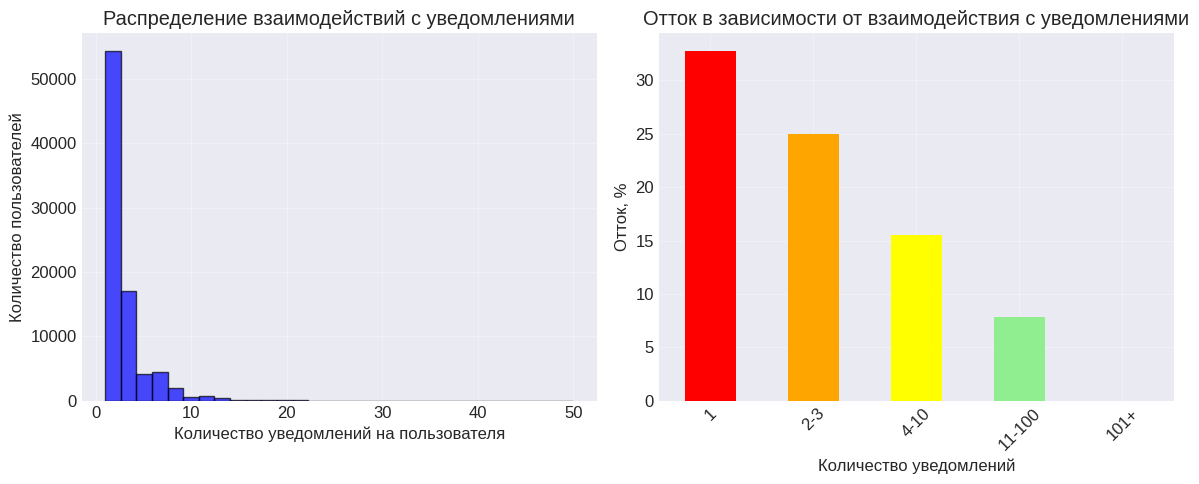

In [86]:
print("\nГЛУБОКИЙ АНАЛИЗ УВЕДОМЛЕНИЙ")


# Фильтруем действия с уведомлениями - ОПТИМИЗИРОВАННЫЙ ПОДХОД
mask = df['action'].notna() & df['action'].str.contains('уведомление', case=False, na=False)
notification_actions = df[mask]

print(f"\nСТАТИСТИКА ПО УВЕДОМЛЕНИЯМ:")
print(f"  • Всего действий с уведомлениями: {len(notification_actions):,}")
print(f"  • Уникальных пользователей: {notification_actions['device_id'].nunique():,}")

# Анализируем, что происходит ПОСЛЕ тапа на уведомление - ОПТИМИЗИРОВАННО

# 1. Быстрая фильтрация - используем группировку вместо циклов
print("\n1. Быстрый анализ через группировку:")

# Находим все тапы на уведомления
notification_taps = df[df['action'] == 'Тап на уведомление'].copy()
print(f"  • Всего тапов на уведомления: {len(notification_taps):,}")

# Сортируем один раз
df_sorted = df.sort_values(['device_id', 'session_id', 'event_dt']).reset_index(drop=True)

# 2. Векторизованный подход - используем shift для поиска следующих действий
print("\n2. Векторизованный анализ:")

# Создаем флаг для тапов на уведомления
df_sorted['is_notification_tap'] = df_sorted['action'] == 'Тап на уведомление'

# Для каждой строки находим следующую строку того же пользователя и сессии
df_sorted['next_screen'] = df_sorted.groupby(['device_id', 'session_id'])['screen'].shift(-1)
df_sorted['next_feature'] = df_sorted.groupby(['device_id', 'session_id'])['feature'].shift(-1)
df_sorted['next_action'] = df_sorted.groupby(['device_id', 'session_id'])['action'].shift(-1)
df_sorted['next_is_churn'] = df_sorted.groupby(['device_id', 'session_id'])['is_churn'].shift(-1)

# Фильтруем только строки с тапами на уведомления, у которых есть следующее действие
notification_with_next = df_sorted[df_sorted['is_notification_tap'] & df_sorted['next_action'].notna()]

print(f"  • Тапов на уведомления с последующим действием: {len(notification_with_next):,}")
print(f"  • Тапов на уведомления без последующего действия: {len(notification_taps) - len(notification_with_next):,}")

if len(notification_with_next) > 0:
    print(f"\nКуда ведут уведомления (следующий экран):")
    next_screens = notification_with_next['next_screen'].value_counts().head(10)
    for screen, count in next_screens.items():
        percentage = count / len(notification_with_next) * 100

        # Отток для этого пути
        subset = notification_with_next[notification_with_next['next_screen'] == screen]
        churn_rate = subset['next_is_churn'].mean() * 100

        print(f"  • {str(screen)[:40]:40s}: {count:6,} ({percentage:.1f}%), отток: {churn_rate:.1f}%")

    print(f"\nКуда ведут уведомления (следующая функция):")
    next_features = notification_with_next['next_feature'].value_counts().head(10)
    for feature, count in next_features.items():
        percentage = count / len(notification_with_next) * 100

        # Отток для этого пути
        subset = notification_with_next[notification_with_next['next_feature'] == feature]
        churn_rate = subset['next_is_churn'].mean() * 100

        print(f"  • {str(feature)[:40]:40s}: {count:6,} ({percentage:.1f}%), отток: {churn_rate:.1f}%")

    print(f"\nКуда ведут уведомления (следующее действие):")
    next_actions_counts = notification_with_next['next_action'].value_counts().head(10)
    for action, count in next_actions_counts.items():
        percentage = count / len(notification_with_next) * 100

        # Отток для этого пути
        subset = notification_with_next[notification_with_next['next_action'] == action]
        churn_rate = subset['next_is_churn'].mean() * 100

        print(f"  • {str(action)[:40]:40s}: {count:6,} ({percentage:.1f}%), отток: {churn_rate:.1f}%")

    # 3. Дополнительный быстрый анализ - что происходит в течение 5 минут после уведомления
    print(f"\n3. Анализ активности в течение 5 минут после уведомления:")

    # Для ускорения берем только первые 10% данных
    sample_size = min(50000, len(notification_with_next))
    notification_sample = notification_with_next.sample(sample_size, random_state=42) if len(notification_with_next) > 50000 else notification_with_next

    # Считаем, сколько пользователей делают более 1 действия после уведомления
    print(f"  • Проанализировано выборка: {len(notification_sample):,} тапов")

    # Удаляем временные колонки для экономии памяти
    df_sorted.drop(['is_notification_tap', 'next_screen', 'next_feature', 'next_action', 'next_is_churn'],
                   axis=1, inplace=True, errors='ignore')
else:
    print("Нет данных о действиях после тапов на уведомления")


# Группируем по пользователям и считаем статистику
notification_users_stats = notification_actions.groupby('device_id').agg({
    'action': 'count',
    'is_churn': 'first',
    'event_dt': ['min', 'max']
})

notification_users_stats.columns = ['notification_count', 'is_churn', 'first_notification', 'last_notification']
notification_users_stats['days_active'] = (notification_users_stats['last_notification'] - notification_users_stats['first_notification']).dt.days

print(f"\nСтатистика по пользователям, взаимодействующим с уведомлениями:")
print(f"  • Среднее уведомлений на пользователя: {notification_users_stats['notification_count'].mean():.1f}")
print(f"  • Медиана уведомлений: {notification_users_stats['notification_count'].median():.1f}")
print(f"  • Отток среди этих пользователей: {notification_users_stats['is_churn'].mean()*100:.1f}%")
print(f"  • Среднее дней активности: {notification_users_stats['days_active'].mean():.1f}")

# 5. Визуализация
print(f"\n5. Визуализация распределения:")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Распределение количества уведомлений на пользователя
notification_counts = notification_users_stats['notification_count'].clip(0, 50)
plt.hist(notification_counts, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Количество уведомлений на пользователя')
plt.ylabel('Количество пользователей')
plt.title('Распределение взаимодействий с уведомлениями')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Сравнение оттока по количеству уведомлений
notification_users_stats['notification_group'] = pd.cut(
    notification_users_stats['notification_count'],
    bins=[0, 1, 3, 10, 100, 1000],
    labels=['1', '2-3', '4-10', '11-100', '101+']
)

churn_by_notif_group = notification_users_stats.groupby('notification_group')['is_churn'].mean() * 100
churn_by_notif_group.plot(kind='bar', color=['red', 'orange', 'yellow', 'lightgreen', 'green'])
plt.xlabel('Количество уведомлений')
plt.ylabel('Отток, %')
plt.title('Отток в зависимости от взаимодействия с уведомлениями')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [87]:
print("\nГЛУБОКИЙ АНАЛИЗ РАЗДЕЛА 'ОПРОСЫ И СОБРАНИЯ'")

# Фильтруем действия, связанные с опросами
survey_actions = df[df['action'].str.contains('опрос|собрани', na=False, case=False)]

print(f"\nСТАТИСТИКА ПО ОПРОСАМ И СОБРАНИЯМ:")
print(f"  • Всего действий с опросами: {len(survey_actions):,}")
print(f"  • Уникальных пользователей: {survey_actions['device_id'].nunique():,}")
print(f"  • Отток среди этих пользователей: {survey_actions['is_churn'].mean()*100:.1f}%")

# Смотрим, какие экраны связаны с опросами
print(f"\nЭКРАНЫ В РАЗДЕЛЕ ОПРОСОВ:")
survey_screens = survey_actions['screen'].value_counts()
for screen, count in survey_screens.head(10).items():
    percentage = count / len(survey_actions) * 100
    print(f"  • {screen:40s}: {count:6,} ({percentage:.1f}%)")

# Анализируем последовательности в разделе опросов
print(f"\nТИПИЧНЫЕ ПОСЛЕДОВАТЕЛЬНОСТИ В РАЗДЕЛЕ ОПРОСОВ:")

# Берем пользователей, которые взаимодействовали с опросами
survey_users = survey_actions['device_id'].unique()

# Анализируем первых 50 пользователей для паттернов
common_patterns = {}
for user_id in survey_users[:50]:
    user_survey_actions = df_sorted[(df_sorted['device_id'] == user_id) &
                                    (df_sorted['action'].str.contains('опрос|собрани', na=False))]

    if len(user_survey_actions) > 0:
        # Берем последовательность действий пользователя в разделе опросов
        actions_sequence = tuple(user_survey_actions['action'].head(5).tolist())
        if actions_sequence:
            common_patterns[actions_sequence] = common_patterns.get(actions_sequence, 0) + 1

if common_patterns:
    print(f"\nНаиболее частые последовательности:")
    for seq, count in sorted(common_patterns.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"\n  • Встречается у {count} пользователей:")
        for i, action in enumerate(seq, 1):
            print(f"    Шаг {i}: {action}")


ГЛУБОКИЙ АНАЛИЗ РАЗДЕЛА 'ОПРОСЫ И СОБРАНИЯ'

СТАТИСТИКА ПО ОПРОСАМ И СОБРАНИЯМ:
  • Всего действий с опросами: 127,634
  • Уникальных пользователей: 46,154
  • Отток среди этих пользователей: 21.8%

ЭКРАНЫ В РАЗДЕЛЕ ОПРОСОВ:
  • Еще                                     : 126,429 (99.1%)
  • Связаться с владельцем ТС               :  1,017 (0.8%)
  • Новая заявка                            :    162 (0.1%)
  • Новое ОСС                               :     26 (0.0%)

ТИПИЧНЫЕ ПОСЛЕДОВАТЕЛЬНОСТИ В РАЗДЕЛЕ ОПРОСОВ:

Наиболее частые последовательности:

  • Встречается у 15 пользователей:
    Шаг 1: Тап на кнопку 'Опросы и собрания собственников'
    Шаг 2: Тап на кнопку 'Опросы и собрания собственников'
    Шаг 3: Тап на кнопку 'Опросы и собрания собственников'
    Шаг 4: Тап на кнопку 'Опросы и собрания собственников'
    Шаг 5: Тап на кнопку 'Опросы и собрания собственников'

  • Встречается у 11 пользователей:
    Шаг 1: Тап на кнопку 'Опросы и собрания собственников'

  • Встречается у 

In [88]:
print("\nАНАЛИЗ КАЧЕСТВА ДАННЫХ И РЕКОМЕНДАЦИИ")


# Создаем признак "есть action" или нет
df['has_action'] = df['action'].notna()

# Анализируем по screen
screen_missing_stats = df.groupby('screen').agg({
    'has_action': ['count', 'mean']
})
screen_missing_stats.columns = ['total_events', 'action_present_rate']
screen_missing_stats['action_present_rate'] = (1 - screen_missing_stats['action_present_rate']) * 100
screen_missing_stats = screen_missing_stats.sort_values('action_present_rate', ascending=False)

print(f"\nЭКРАНЫ С НАИБОЛЬШИМ % ПРОПУСКОВ В ACTION:")
for screen, row in screen_missing_stats.head(10).iterrows():
    print(f"  • {screen:40s}: {row['action_present_rate']:.1f}% пропусков ({row['total_events']:,} событий)")

# Анализируем по feature
feature_missing_stats = df.groupby('feature').agg({
    'has_action': ['count', 'mean']
})
feature_missing_stats.columns = ['total_events', 'action_present_rate']
feature_missing_stats['action_present_rate'] = (1 - feature_missing_stats['action_present_rate']) * 100
feature_missing_stats = feature_missing_stats.sort_values('action_present_rate', ascending=False)

print(f"\nФУНКЦИИ С НАИБОЛЬШИМ % ПРОПУСКОВ В ACTION:")
for feature, row in feature_missing_stats.head(10).iterrows():
    print(f"  • {feature:40s}: {row['action_present_rate']:.1f}% пропусков ({row['total_events']:,} событий)")


АНАЛИЗ КАЧЕСТВА ДАННЫХ И РЕКОМЕНДАЦИИ

ЭКРАНЫ С НАИБОЛЬШИМ % ПРОПУСКОВ В ACTION:
  • Техподдержка                            : 87.5% пропусков (542.0 событий)
  • Связаться с владельцем ТС               : 86.5% пропусков (7,528.0 событий)
  • Еще                                     : 67.2% пропусков (1,733,831.0 событий)
  • Мой дом                                 : 64.5% пропусков (78,784.0 событий)
  • Мои баллы                               : 64.5% пропусков (41,161.0 событий)
  • Новое ОСС                               : 59.4% пропусков (19,939.0 событий)
  • Заявки                                  : 55.9% пропусков (313,188.0 событий)
  • Новый адрес                             : 53.3% пропусков (3,157.0 событий)
  • Гостевой доступ                         : 43.1% пропусков (21,738.0 событий)
  • Новая заявка                            : 36.9% пропусков (837,026.0 событий)

ФУНКЦИИ С НАИБОЛЬШИМ % ПРОПУСКОВ В ACTION:
  • Открытие экрана                         : 98.7% пропусков (1

In [89]:
print("\nАНАЛИЗ 'МЕРТВЫХ' УВЕДОМЛЕНИЙ")

# Анализируем уведомления без следующего действия
df_sorted = df.sort_values(['device_id', 'session_id', 'event_dt']).reset_index(drop=True)

# Создаем временные колонки для анализа
df_sorted['is_notification_tap'] = df_sorted['action'] == 'Тап на уведомление'
df_sorted['has_next_action'] = df_sorted.groupby(['device_id', 'session_id'])['action'].shift(-1).notna()

# Находим "мертвые" уведомления
dead_notifications = df_sorted[df_sorted['is_notification_tap'] & ~df_sorted['has_next_action']]

print(f"\nСТАТИСТИКА ПО 'МЕРТВЫМ' УВЕДОМЛЕНИЯМ:")
print(f"  • Количество: {len(dead_notifications):,} ({(len(dead_notifications)/len(notification_taps)*100):.1f}% от всех тапов)")
print(f"  • Уникальных пользователей: {dead_notifications['device_id'].nunique():,}")
print(f"  • Отток среди этих пользователей: {dead_notifications['is_churn'].mean()*100:.1f}%")

# Анализируем, что было ДО этих уведомлений
print(f"\nЧТО БЫЛО ДО 'МЕРТВЫХ' УВЕДОМЛЕНИЙ:")

# Для каждого мертвого уведомления находим предыдущее действие
df_sorted['prev_action'] = df_sorted.groupby(['device_id', 'session_id'])['action'].shift(1)
df_sorted['prev_screen'] = df_sorted.groupby(['device_id', 'session_id'])['screen'].shift(1)

dead_with_prev = df_sorted[df_sorted['is_notification_tap'] & ~df_sorted['has_next_action'] & df_sorted['prev_action'].notna()]

if len(dead_with_prev) > 0:
    print(f"\nС каким экраном работали перед 'мертвым' уведомлением:")
    prev_screens = dead_with_prev['prev_screen'].value_counts().head(10)
    for screen, count in prev_screens.items():
        percentage = count / len(dead_with_prev) * 100
        print(f"  • {str(screen)[:40]:40s}: {count:6,} ({percentage:.1f}%)")

    print(f"\nКакое действие делали перед 'мертвым' уведомлением:")
    prev_actions = dead_with_prev['prev_action'].value_counts().head(10)
    for action, count in prev_actions.items():
        percentage = count / len(dead_with_prev) * 100
        print(f"  • {str(action)[:40]:40s}: {count:6,} ({percentage:.1f}%)")

# Анализ временных характеристик
print(f"\nВРЕМЕННОЙ АНАЛИЗ 'МЕРТВЫХ' УВЕДОМЛЕНИЙ:")

# Рассчитываем время между предыдущим действием и уведомлением
if len(dead_with_prev) > 0:
    dead_with_prev['time_since_prev'] = (dead_with_prev['event_dt'] - dead_with_prev.groupby(['device_id', 'session_id'])['event_dt'].shift(1)).dt.total_seconds()

    print(f"  • Среднее время с предыдущего действия: {dead_with_prev['time_since_prev'].mean()/60:.1f} минут")
    print(f"  • Медианное время: {dead_with_prev['time_since_prev'].median()/60:.1f} минут")
    print(f"  • 75% случаев: ≤ {dead_with_prev['time_since_prev'].quantile(0.75)/60:.1f} минут")

# Удаляем временные колонки
df_sorted.drop(['is_notification_tap', 'has_next_action', 'prev_action', 'prev_screen'],
               axis=1, inplace=True, errors='ignore')


АНАЛИЗ 'МЕРТВЫХ' УВЕДОМЛЕНИЙ

СТАТИСТИКА ПО 'МЕРТВЫМ' УВЕДОМЛЕНИЯМ:
  • Количество: 125,057 (53.3% от всех тапов)
  • Уникальных пользователей: 75,198
  • Отток среди этих пользователей: 18.8%

ЧТО БЫЛО ДО 'МЕРТВЫХ' УВЕДОМЛЕНИЙ:

С каким экраном работали перед 'мертвым' уведомлением:
  • Важное                                  : 40,031 (87.4%)
  • Еще                                     :  3,477 (7.6%)
  • Новая заявка                            :  1,315 (2.9%)
  • Услуги                                  :    414 (0.9%)
  • Гостевой доступ                         :    165 (0.4%)
  • Мой дом                                 :    134 (0.3%)
  • Заявки                                  :    116 (0.3%)
  • Мои баллы                               :     60 (0.1%)
  • Объявления                              :     36 (0.1%)
  • Новый адрес                             :     33 (0.1%)

Какое действие делали перед 'мертвым' уведомлением:
  • Тап на уведомление                      : 40,031 (87.4%)

In [90]:
print("\nГЛУБОКИЙ АНАЛИЗ: ПОЧЕМУ ЛЮДИ УХОДЯТ ИЗ РАЗДЕЛА ОПРОСОВ")


# Фильтруем пользователей, которые заходили в раздел опросов
survey_users = df[df['action'].str.contains('опрос|собрани', na=False, case=False)]['device_id'].unique()

print(f"  • Всего пользователей раздела: {len(survey_users):,}")
print(f"  • Отток среди них: {df[df['device_id'].isin(survey_users)]['is_churn'].mean()*100:.1f}%")


survey_actions_detail = df[df['device_id'].isin(survey_users) &
                          df['action'].str.contains('опрос|собрани', na=False, case=False)].copy()

# Группируем по пользователям
user_survey_stats = survey_actions_detail.groupby('device_id').agg({
    'action': 'count',
    'screen': lambda x: x.nunique(),
    'is_churn': 'first',
    'event_dt': ['min', 'max']
})

user_survey_stats.columns = ['survey_actions', 'unique_screens', 'is_churn', 'first_survey', 'last_survey']
user_survey_stats['survey_duration_days'] = (user_survey_stats['last_survey'] - user_survey_stats['first_survey']).dt.days

print(f"  • Среднее действий в разделе: {user_survey_stats['survey_actions'].mean():.1f}")
print(f"  • Медиана действий: {user_survey_stats['survey_actions'].median():.1f}")
print(f"  • Уникальных экранов на пользователя: {user_survey_stats['unique_screens'].mean():.1f}")
print(f"  • Средняя длительность взаимодействия: {user_survey_stats['survey_duration_days'].mean():.1f} дней")

# Анализ: что делают ПОСЛЕ посещения раздела опросов
print(f"\nЧТО ДЕЛАЮТ ПОСЛЕ ПОСЕЩЕНИЯ РАЗДЕЛА ОПРОСОВ:")

# Находим последнее действие каждого пользователя в разделе опросов
last_survey_actions = survey_actions_detail.sort_values(['device_id', 'event_dt']).groupby('device_id').last()

# Находим следующее действие после последнего в разделе опросов
df_sorted = df.sort_values(['device_id', 'session_id', 'event_dt'])

next_after_survey = []
for device_id in last_survey_actions.index[:1000]:  # Ограничиваем для скорости
    user_actions = df_sorted[df_sorted['device_id'] == device_id]
    last_survey_idx = user_actions[user_actions.index.isin(last_survey_actions.index)].index

    if len(last_survey_idx) > 0:
        last_idx = last_survey_idx[0]
        user_actions_sorted = user_actions.sort_index()

        # Находим индекс последнего действия в разделе опросов
        last_survey_pos = user_actions_sorted.index.get_loc(last_idx)

        # Ищем следующее действие
        if last_survey_pos + 1 < len(user_actions_sorted):
            next_action = user_actions_sorted.iloc[last_survey_pos + 1]
            next_after_survey.append({
                'device_id': device_id,
                'next_action': next_action['action'],
                'next_screen': next_action['screen'],
                'next_feature': next_action['feature'],
                'time_diff_minutes': (next_action['event_dt'] - user_actions_sorted.iloc[last_survey_pos]['event_dt']).total_seconds() / 60,
                'is_churn': next_action['is_churn']
            })

if next_after_survey:
    next_after_df = pd.DataFrame(next_after_survey)

    print(f"\nСледующий экран после раздела опросов:")
    next_screens = next_after_df['next_screen'].value_counts().head(10)
    for screen, count in next_screens.items():
        percentage = count / len(next_after_df) * 100
        churn_rate = next_after_df[next_after_df['next_screen'] == screen]['is_churn'].mean() * 100
        print(f"  • {str(screen)[:40]:40s}: {count:6,} ({percentage:.1f}%), отток: {churn_rate:.1f}%")

    print(f"\nСледующее действие после раздела опросов:")
    next_actions = next_after_df['next_action'].value_counts().head(10)
    for action, count in next_actions.items():
        percentage = count / len(next_after_df) * 100
        churn_rate = next_after_df[next_after_df['next_action'] == action]['is_churn'].mean() * 100
        print(f"  • {str(action)[:40]:40s}: {count:6,} ({percentage:.1f}%), отток: {churn_rate:.1f}%")

    print(f"\nВремя до следующего действия:")
    print(f"  • Среднее: {next_after_df['time_diff_minutes'].mean():.1f} минут")
    print(f"  • Медиана: {next_after_df['time_diff_minutes'].median():.1f} минут")
    print(f"  • 75%: ≤ {next_after_df['time_diff_minutes'].quantile(0.75):.1f} минут")


ГЛУБОКИЙ АНАЛИЗ: ПОЧЕМУ ЛЮДИ УХОДЯТ ИЗ РАЗДЕЛА ОПРОСОВ
  • Всего пользователей раздела: 46,154
  • Отток среди них: 11.1%
  • Среднее действий в разделе: 2.8
  • Медиана действий: 1.0
  • Уникальных экранов на пользователя: 1.0
  • Средняя длительность взаимодействия: 4.6 дней

ЧТО ДЕЛАЮТ ПОСЛЕ ПОСЕЩЕНИЯ РАЗДЕЛА ОПРОСОВ:

Следующий экран после раздела опросов:
  • Еще                                     :    536 (68.3%), отток: 9.7%
  • Важное                                  :     96 (12.2%), отток: 13.5%
  • Новая заявка                            :     82 (10.4%), отток: 6.1%
  • Заявки                                  :     22 (2.8%), отток: 0.0%
  • Мой дом                                 :     18 (2.3%), отток: 0.0%
  • Услуги                                  :     12 (1.5%), отток: 16.7%
  • Новое ОСС                               :      8 (1.0%), отток: 12.5%
  • Гостевой доступ                         :      5 (0.6%), отток: 0.0%
  • Мои баллы                               : 

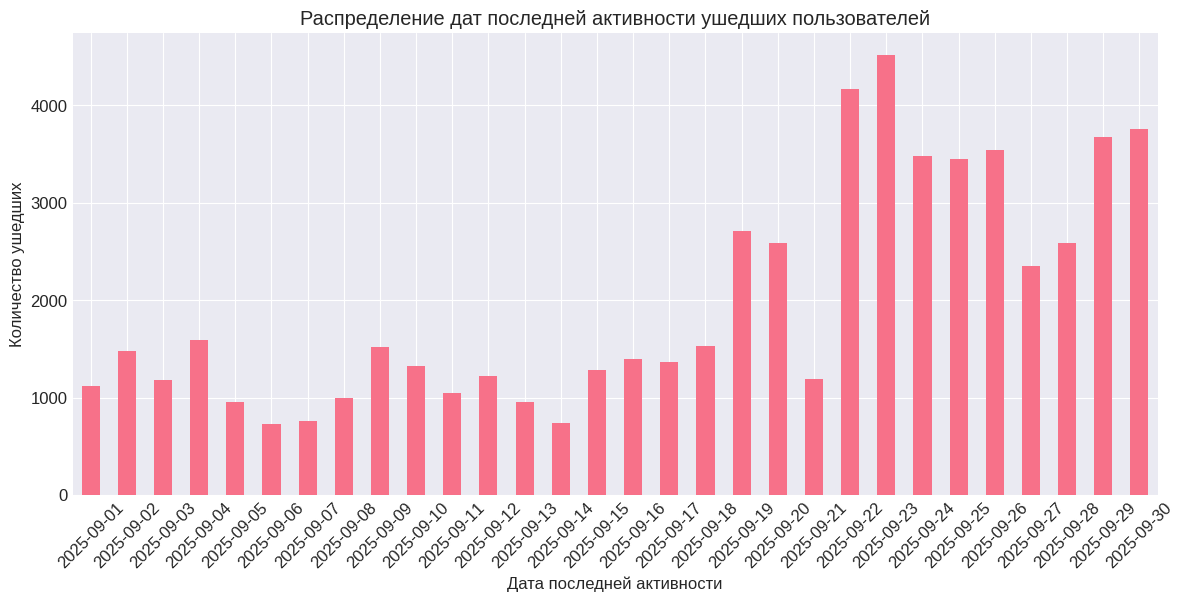

In [94]:
# Распределение дат последней активности ушедших
last_activity_dates = user_last_activity[user_last_activity.index.isin(churned_users)]
last_activity_by_day = last_activity_dates.dt.date.value_counts().sort_index()

# Строим график: когда пики оттока?
plt.figure(figsize=(14, 6))
last_activity_by_day.plot(kind='bar')
plt.title('Распределение дат последней активности ушедших пользователей')
plt.xlabel('Дата последней активности')
plt.ylabel('Количество ушедших')
plt.xticks(rotation=45)
plt.show()